In [1]:
import math
from glob import glob
import os

import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from transformers.models.deprecated.deta.image_processing_deta import masks_to_boxes
from twisted.conch.insults.window import horizontalLine

from template_extraction import *

from scoring import *
from border_and_title import *
from utils import remove_similar_lines

files = [
    "../../data/original/Good/300-014820.pdf",
    "../../data/original/Good/300-014823.pdf",
    "../../data/original/Good/300-014821.pdf",
    "../../data/original/Good/300-014822.pdf"
]
# files = [
#     "../../data/original/Ugly/000.000.537.pdf",
#     "../../data/original/Ugly/000.001.296.pdf",
#     "../../data/original/Ugly/000.001.360.pdf",
#     "../../data/original/Ugly/000.001.389.pdf",
#     "../../data/original/Ugly/000.895.652.pdf",
#     "../../data/original/Ugly/000.895.659.pdf",
#     "../../data/original/Ugly/000.895.701 (1).pdf"
# ]
# files = [
#     "../../data/original/Ugly/000.001.024.pdf",
#     "../../data/original/Ugly/000.001.423.pdf",
# ]
# files = [
#     "../../data/original/Ugly/000.001.303.pdf",
#     "../../data/original/Ugly/000.001.373.pdf",
# ]
# files = [
#     "../../data/original/Ugly/000.895.681.pdf",
#     "../../data/original/Ugly/000.895.684.pdf",
#     "../../data/original/Ugly/000.895.692.pdf",
# ]
# files = [
#     "../../data/original/Ugly/1.pdf",
#     "../../data/original/Ugly/2.pdf",
#     "../../data/original/Ugly/3.pdf",
#     "../../data/original/Ugly/4.pdf",
#     "../../data/original/Ugly/5.pdf",
#     "../../data/original/Ugly/6.pdf",
#     "../../data/original/Ugly/7.pdf",
#     "../../data/original/Ugly/8.pdf",
#     "../../data/original/Ugly/9.pdf",
#     "../../data/original/Ugly/10.pdf",
#     "../../data/original/Ugly/11.pdf"
# ]
# files = [
#     "../../data/original/Good/15316-100-D-006_Sheet1.pdf",
#     "../../data/original/Good/15316-100-D-020_Sheet2.pdf",
#     "../../data/original/Good/15316-100-D-040_Sheet1.pdf",
#     "../../data/original/Good/15316-100-D-041_Sheet1.pdf"
# ]

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

def read_pdf(pdf_path):
    pages = convert_from_path(pdf_path, dpi=300)
    img = np.array(pages[0])
    print(img.shape)
    img = im_resize(img)
    return img

In [2]:
structures = []
images = []

for f in files:
    img = read_pdf(f)

    images.append(img)
    title_contours, line_90, data = detect_probable_title_sections(img, return_states=True)
    ocr_result = data["ocr_result"]
    mask = data["mask"]

    im_h, im_w, _ = img.shape
    words = process_text(ocr_result, im_h, im_w)
    img_comp = img.copy()

    for idx, row in words.iterrows():
        bx1, by1, bx2, by2 = row[["x1", "y1", "x2", "y2"]].astype(int)
        cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (255, 255, 255), cv2.FILLED)

    structures.append(cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR))

(3301, 5100, 3)
(3301, 5100, 3)
(3301, 5100, 3)
(3301, 5100, 3)


Image Similarity: 86.0823%
Image Similarity: 88.7206%
Image Similarity: 85.1641%


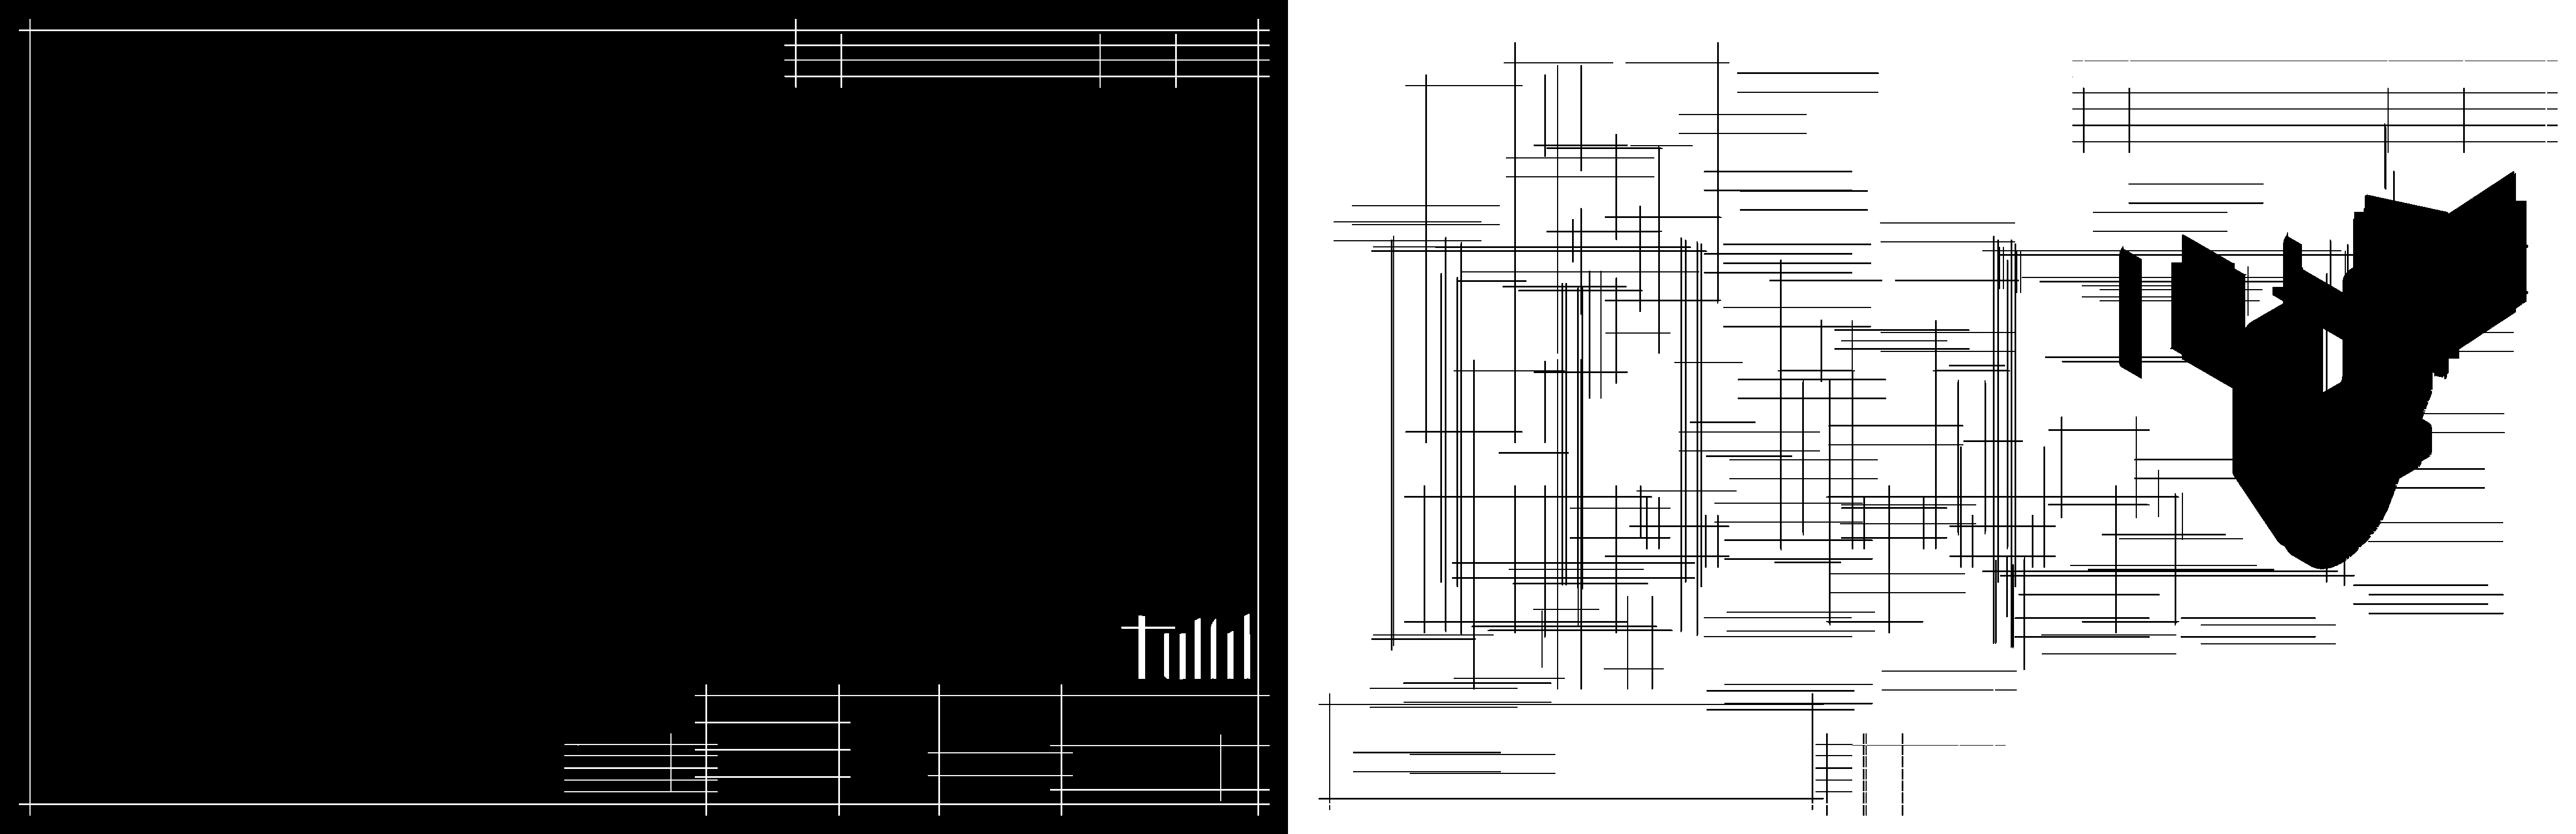

In [3]:
template, common_mask = find_common_region(structures)
template_height, template_width = template.shape[:2]
Image.fromarray(np.hstack((template, common_mask)))

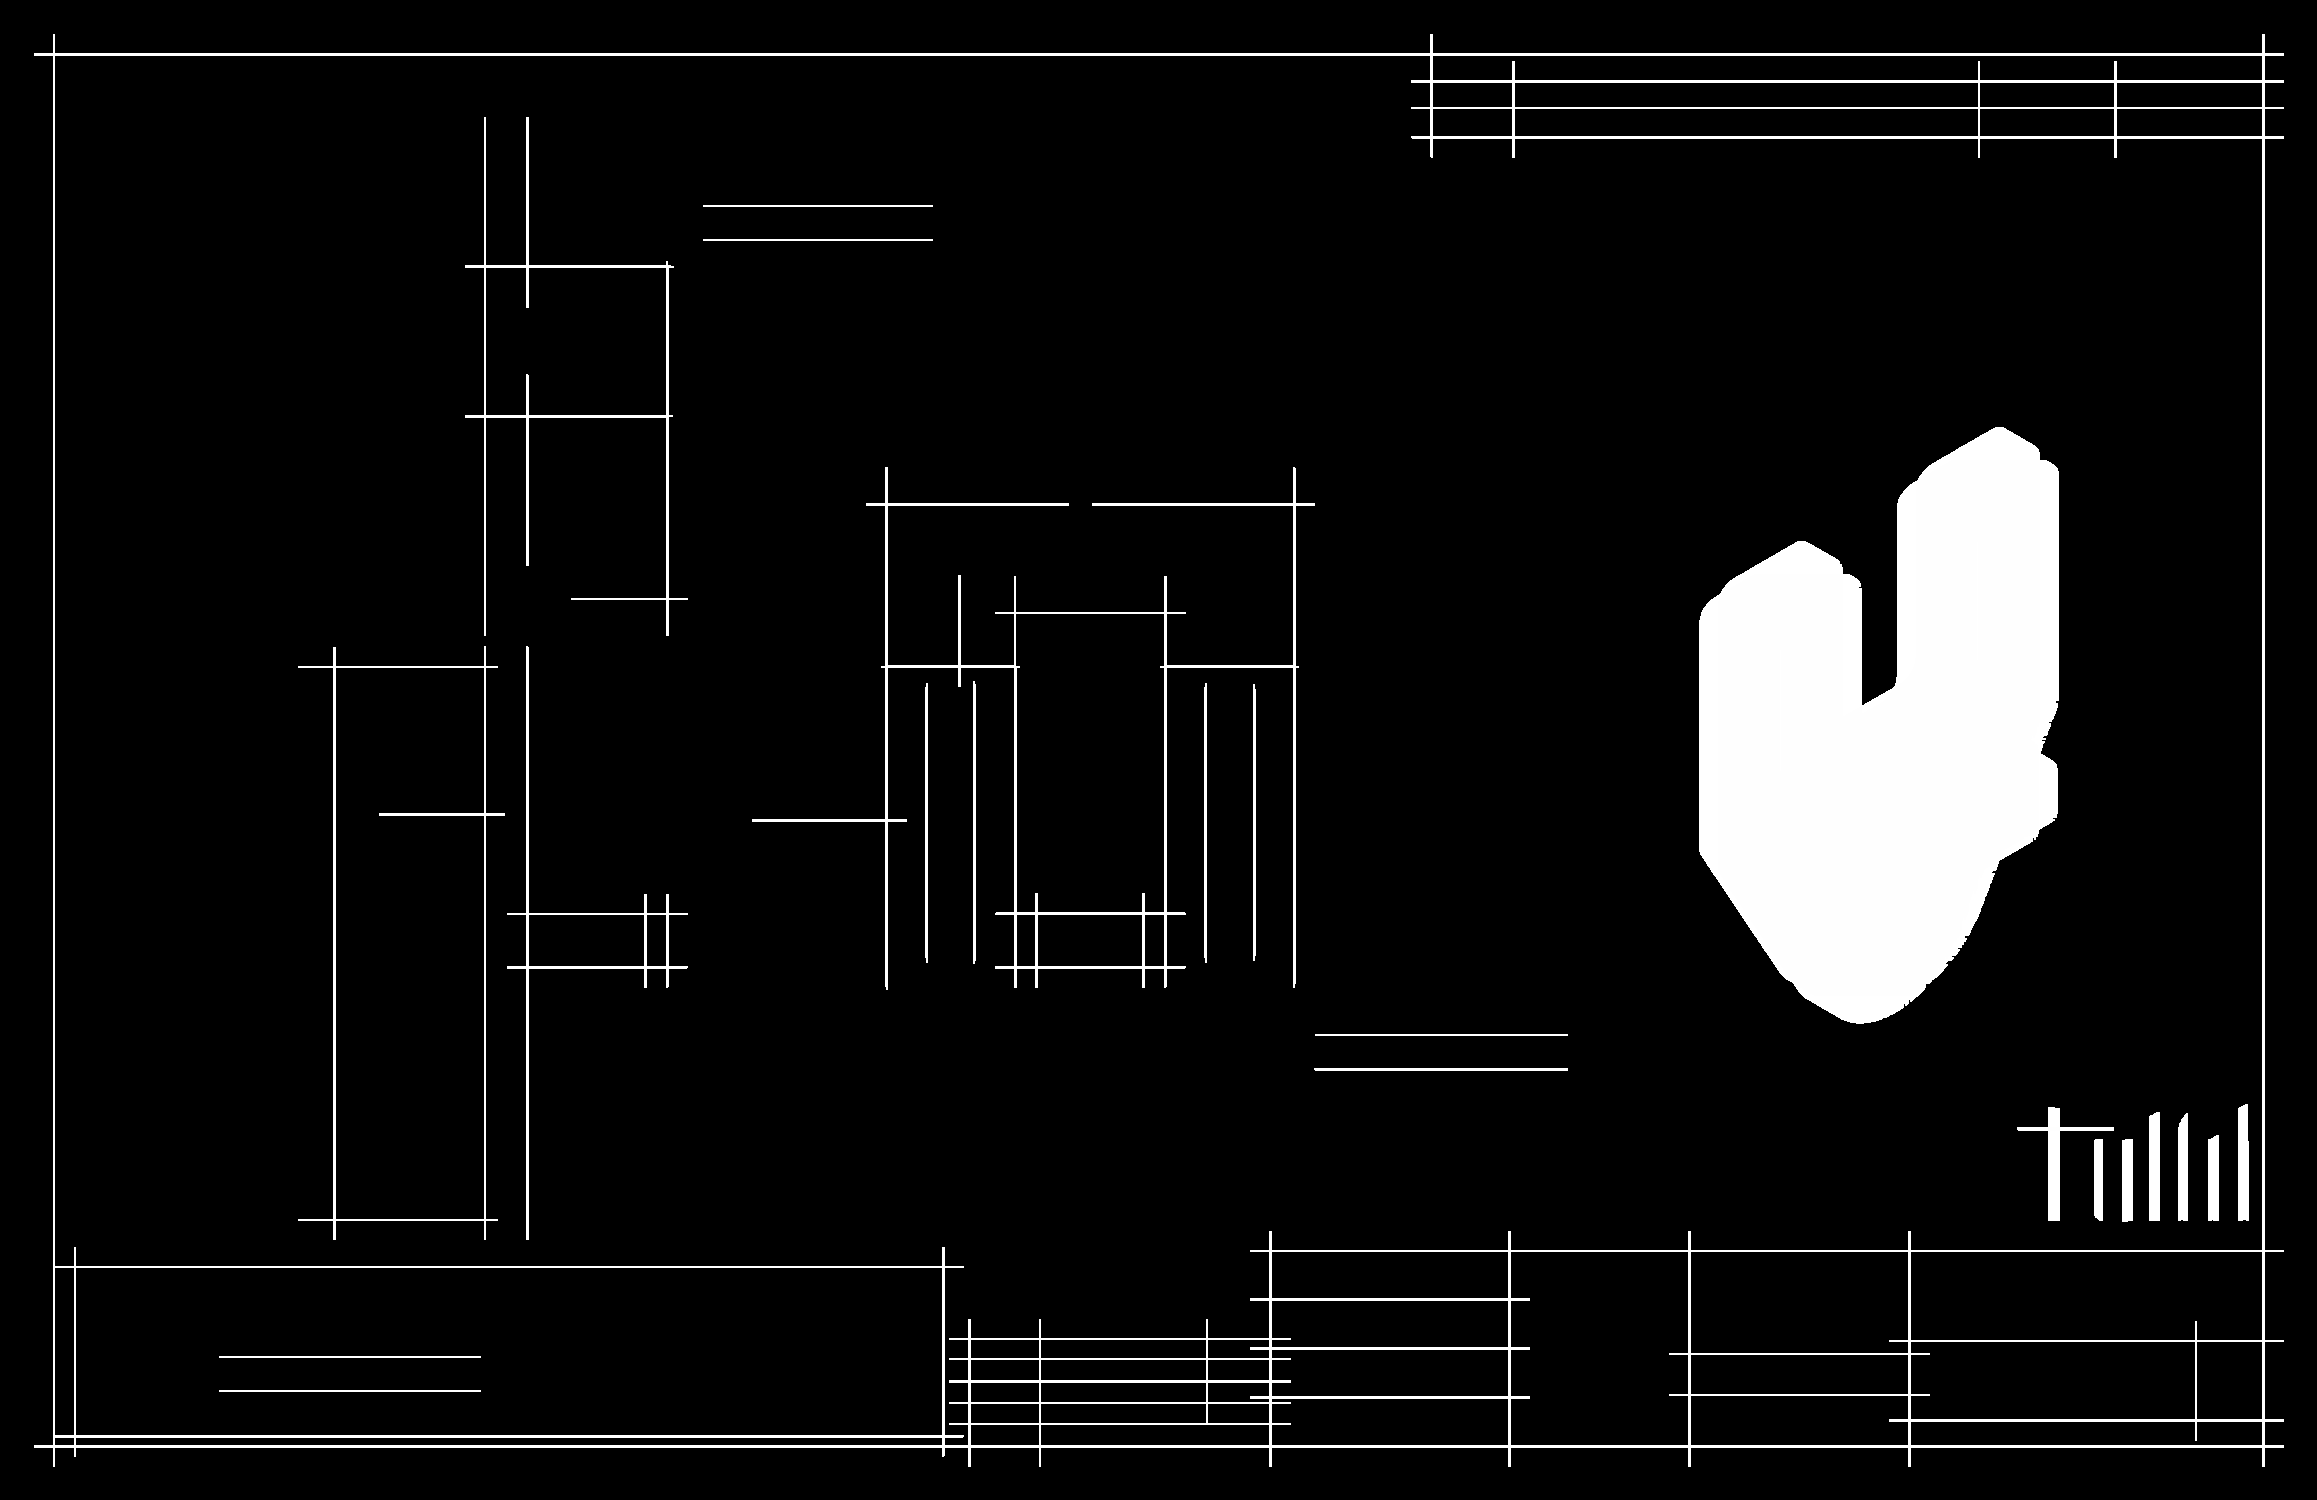

In [4]:
Image.fromarray(structures[0])

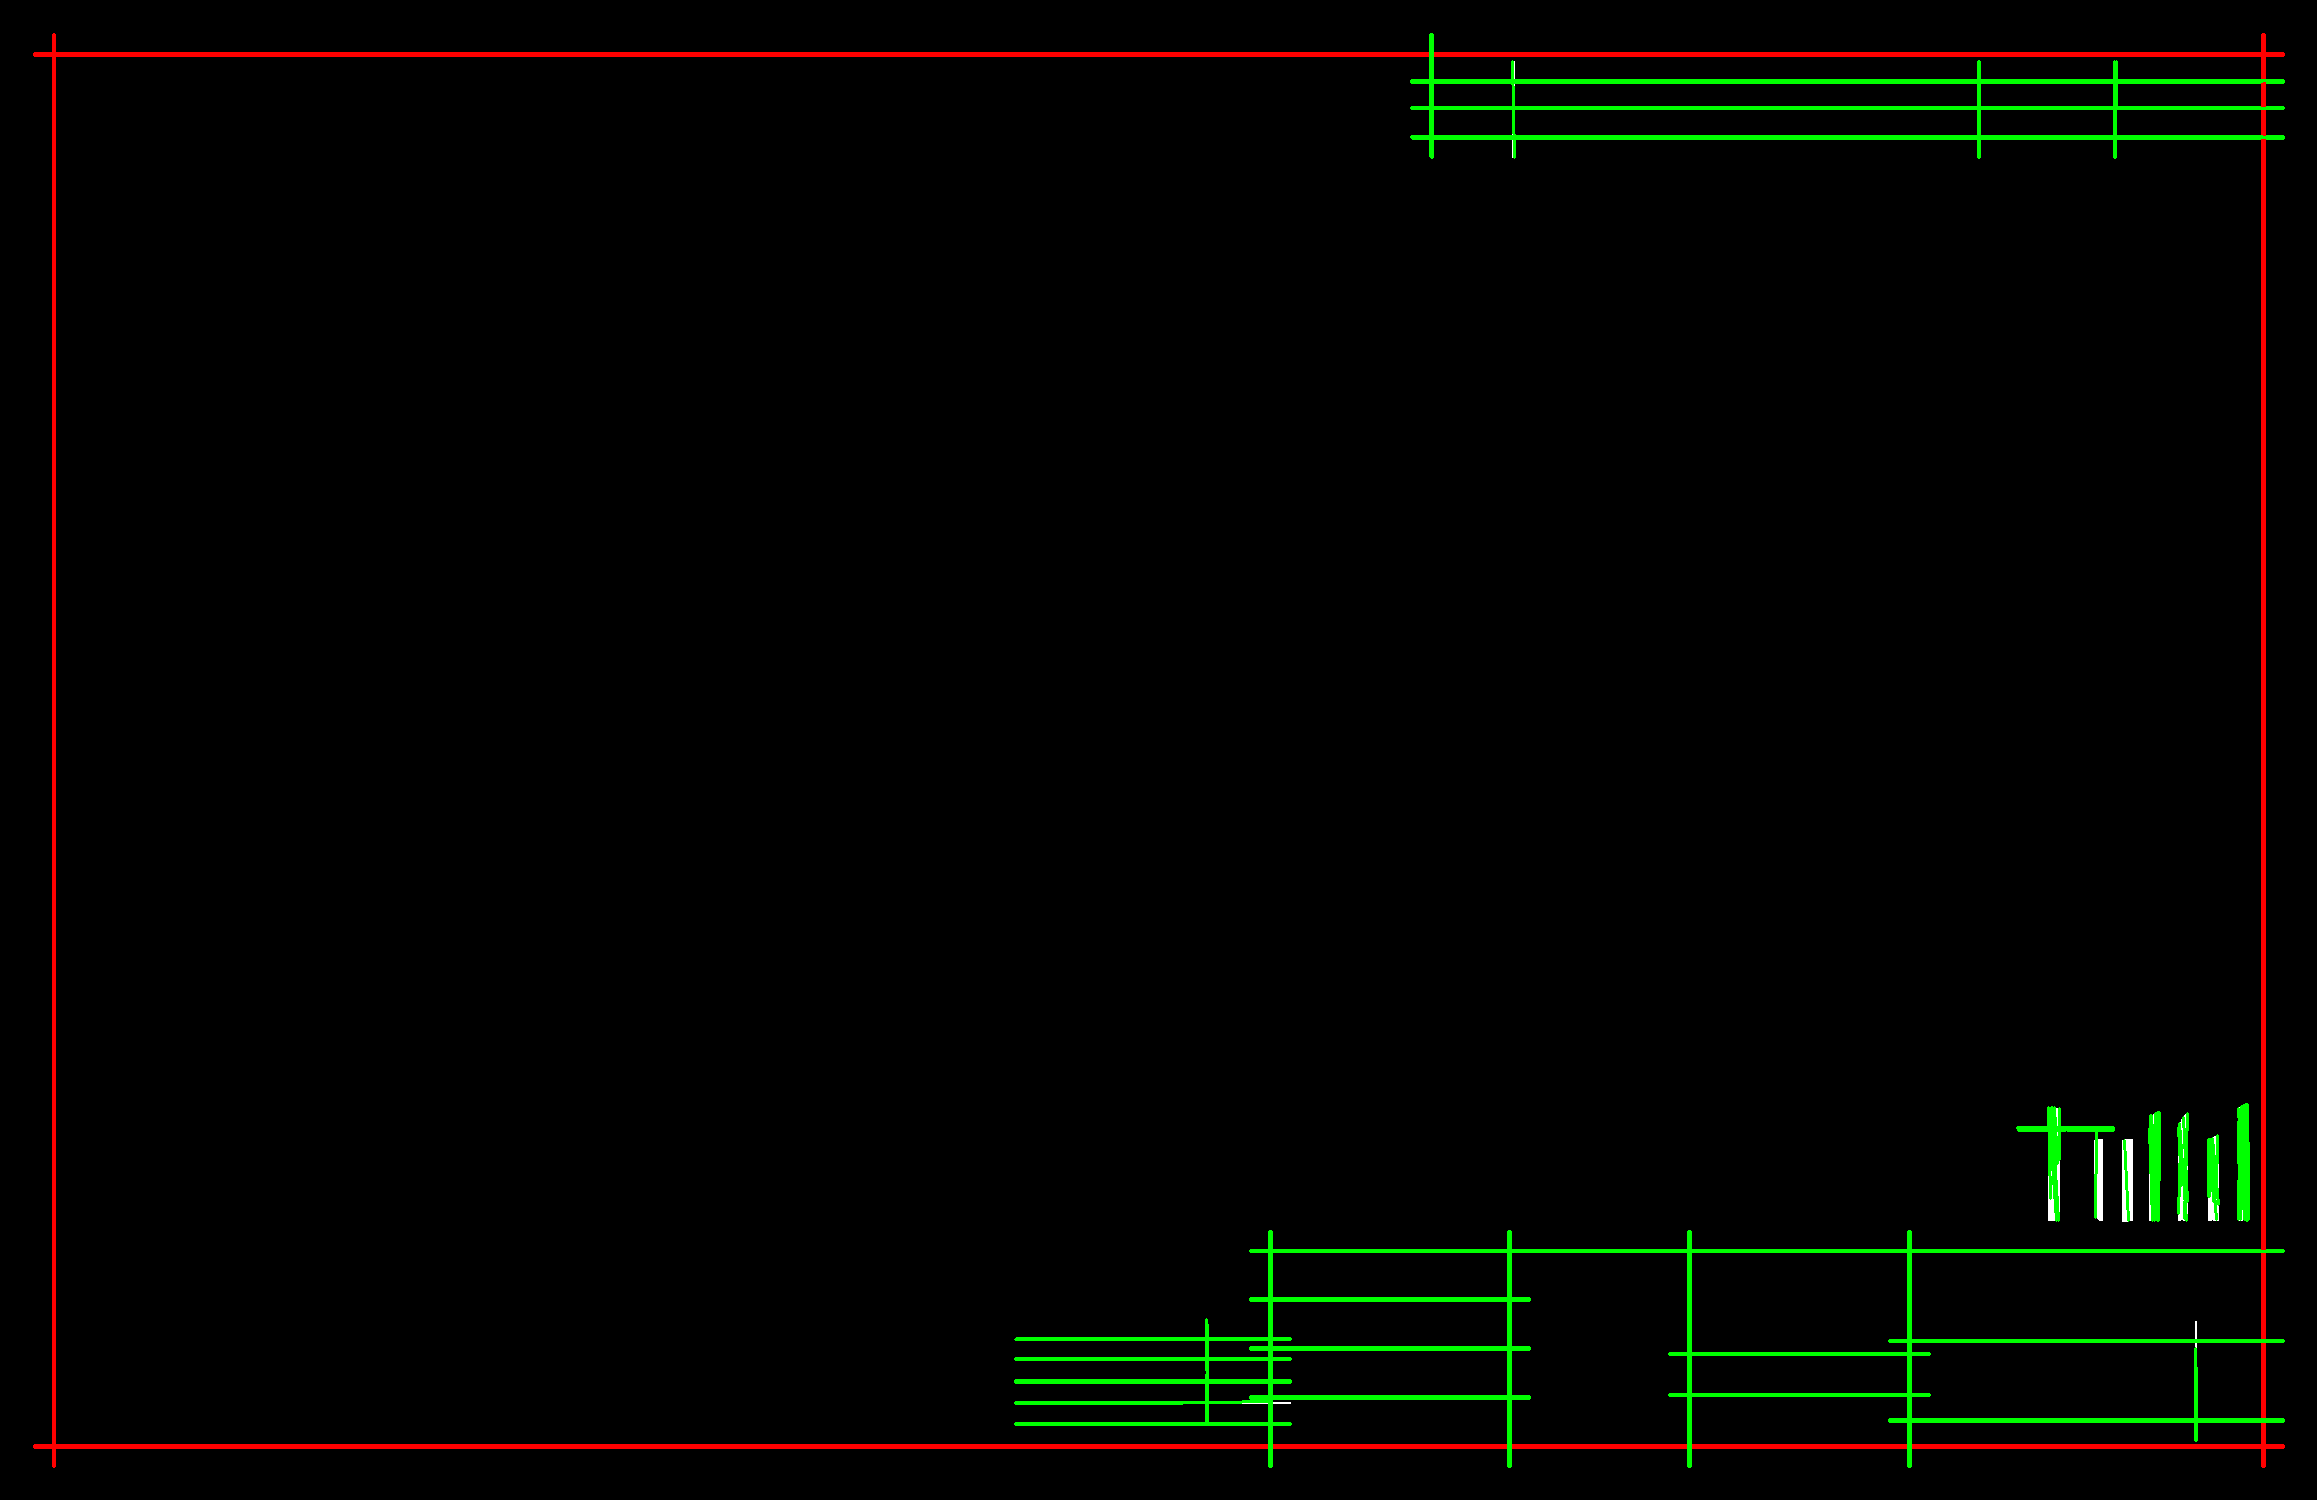

In [5]:
temp_copy = template.copy()
temp_height, temp_width = temp_copy.shape[:2]

gray = cv2.cvtColor(temp_copy, cv2.COLOR_BGR2GRAY)
straight_lines = cv2.HoughLinesP(gray, 1, np.pi / 180, 15, np.array([]), 50, 10)
straight_lines = straight_lines.squeeze(axis=1)

length = [calculate_line_length(straight_line) for straight_line in straight_lines]

for line, l in zip(straight_lines, length):
    x1, y1, x2, y2 = line
    if l > int((temp_width * 95) / 100):
        cv2.line(temp_copy, (x1, y1), (x2, y2), color, thickness)
    elif l > int((temp_height * 95) / 100):
        cv2.line(temp_copy, (x1, y1), (x2, y2), color, thickness)
    else:
        cv2.line(temp_copy, (x1, y1), (x2, y2), (0, 255, 0), thickness)

Image.fromarray(temp_copy)

In [6]:
straight_lines

array([[  34, 1445, 2283, 1445],
       [  34, 1447, 2283, 1447],
       [  34, 1446, 2283, 1446],
       [  34,   53, 2283,   53],
       [  34,   55, 2283,   55],
       [  34,   54, 2283,   54],
       [1250, 1250, 2283, 1250],
       [1411,  107, 2283,  107],
       [1412,  138, 2283,  138],
       [2263, 1466, 2263,   34],
       [1411,   82, 2283,   82],
       [  53, 1466,   53,   34],
       [  54, 1466,   54,   34],
       [2262, 1466, 2262,   34],
       [1411,   81, 2283,   81],
       [1411,  136, 2283,  136],
       [2264, 1466, 2264,   34],
       [1411,   80, 2283,   80],
       [1411,  108, 2283,  108],
       [1250, 1251, 2283, 1251],
       [1411,  137, 2283,  137],
       [1889, 1421, 2283, 1421],
       [1889, 1419, 2283, 1419],
       [1889, 1420, 2283, 1420],
       [1250, 1396, 1529, 1396],
       [1015, 1381, 1290, 1381],
       [1250, 1300, 1529, 1300],
       [1889, 1340, 2283, 1340],
       [1015, 1339, 1290, 1339],
       [1015, 1358, 1290, 1358],
       [10

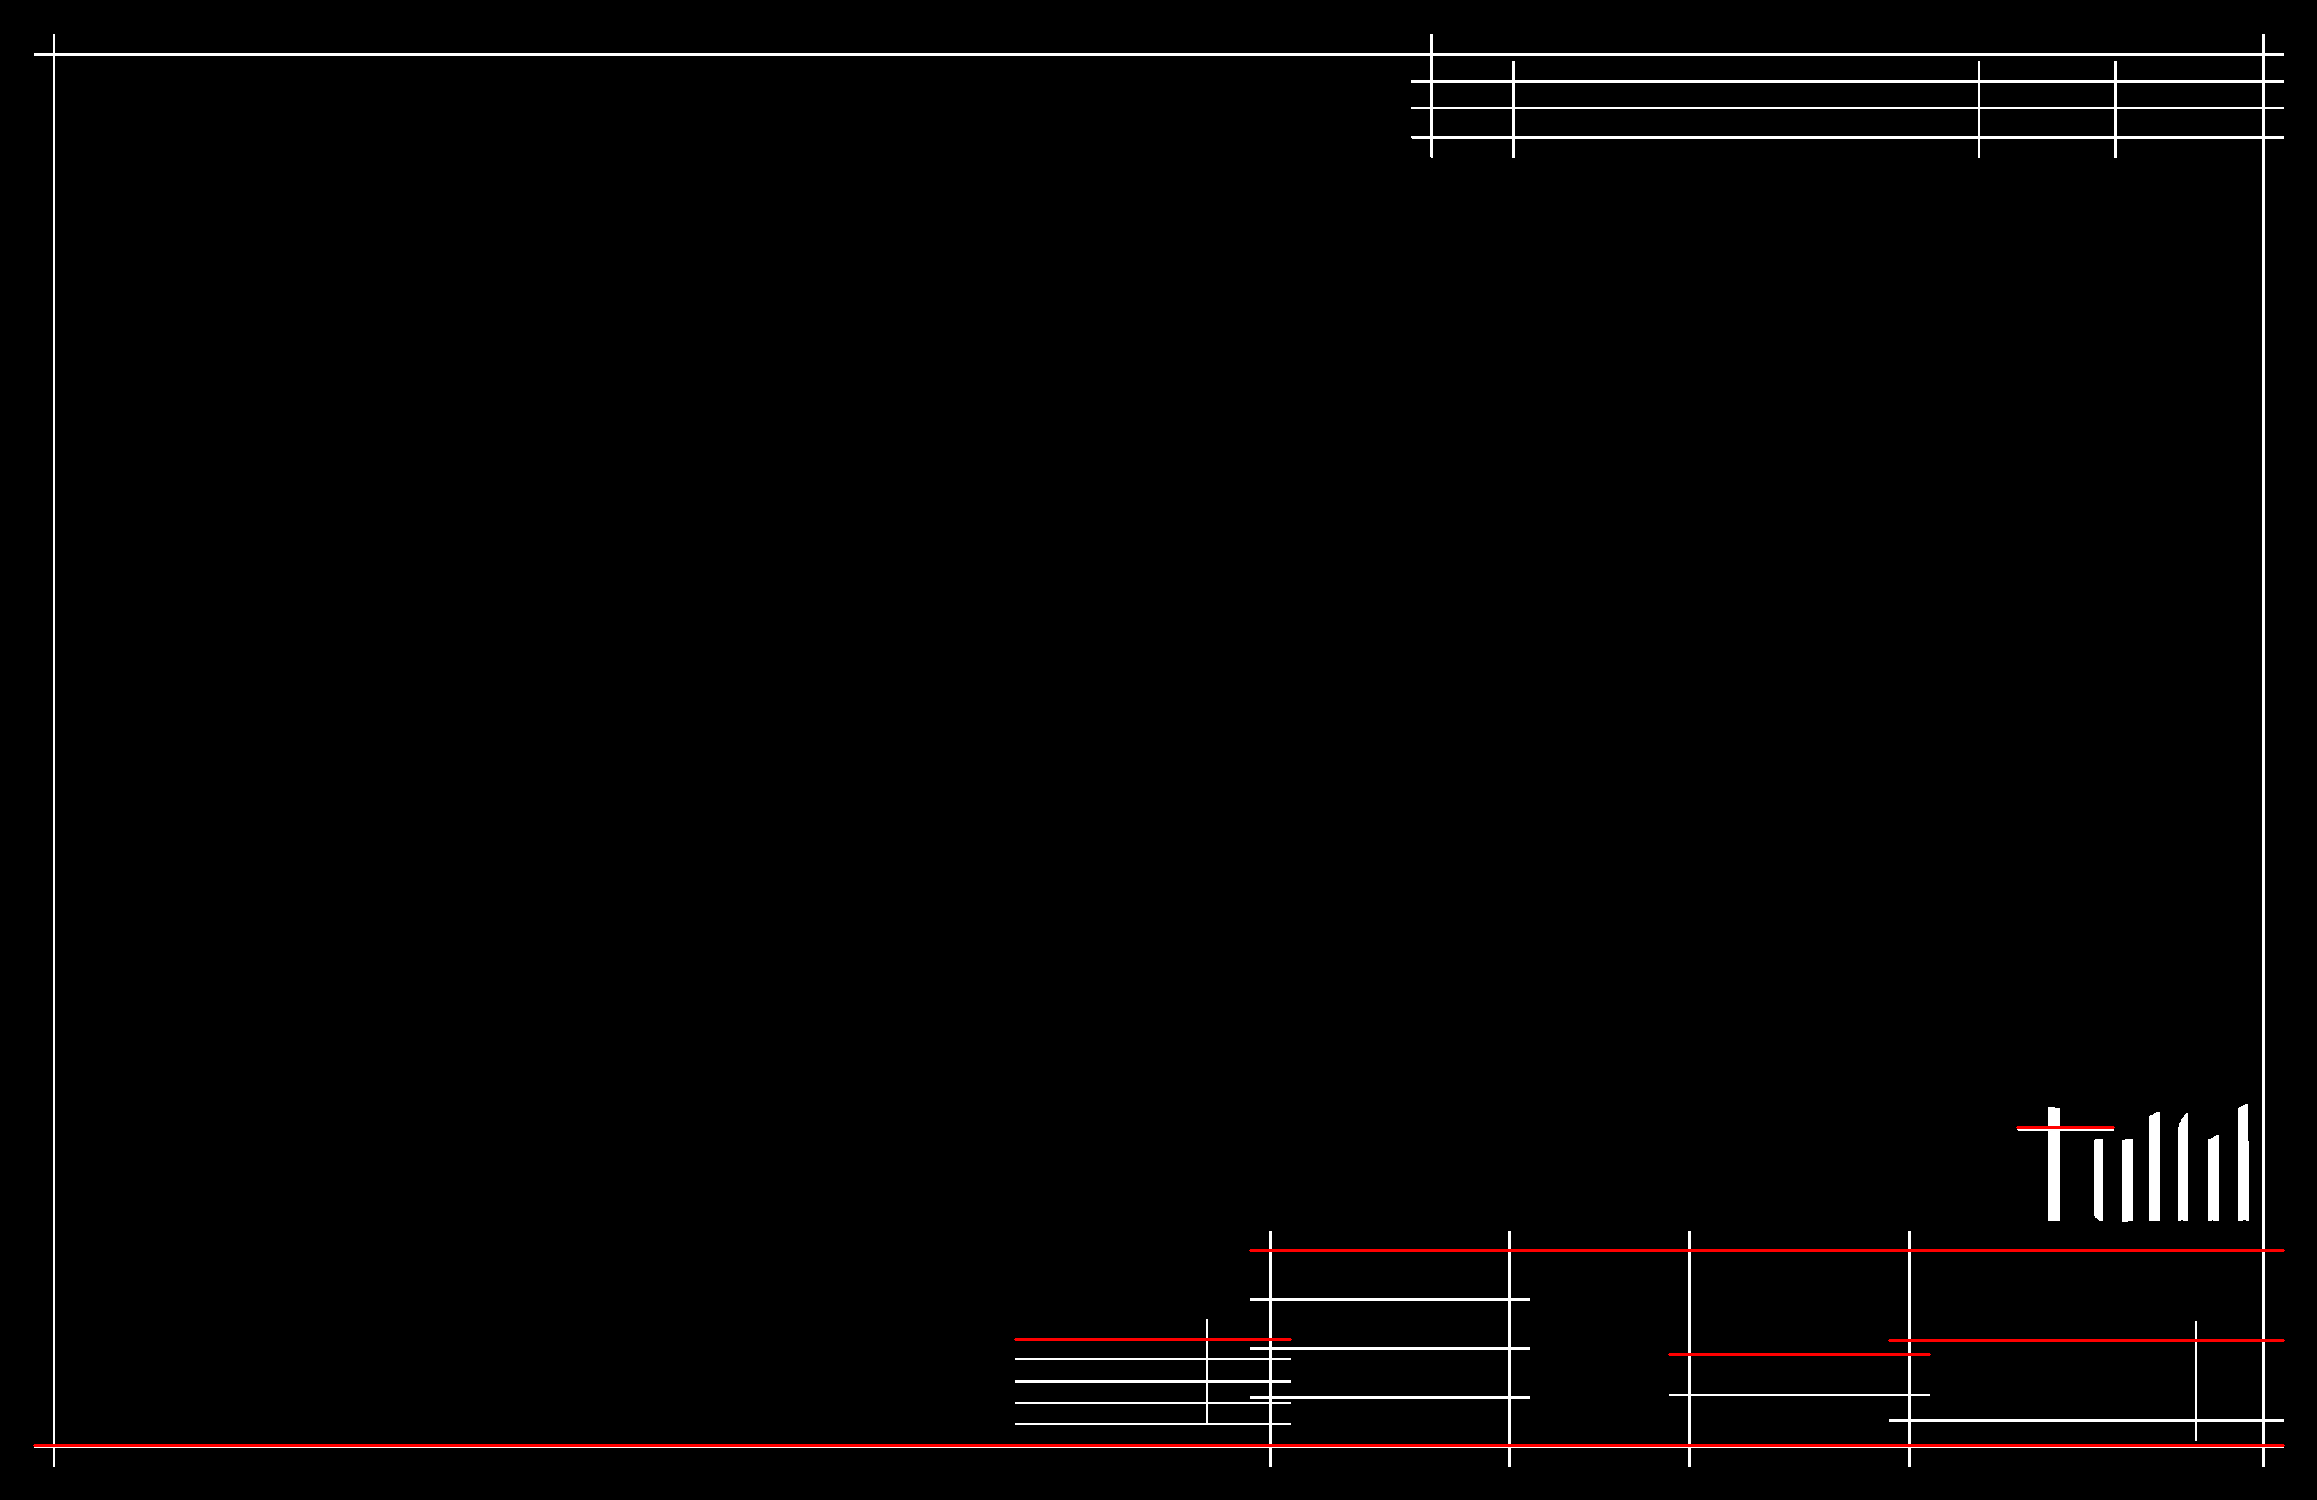

In [7]:
def select_top_right_lines(lines):
    lines = np.array(lines)
    selected_lines = []

    while len(lines) > 0:
        lines = sorted(lines, key=lambda x: (-x[0], x[1]))

        picked_line = lines[0]
        selected_lines.append(picked_line)
        x1_pick, _, x2_pick, _ = picked_line

        new_lines = []
        for line in lines[1:]:
            x1, _, x2, _ = line
            if not (x1 >= min(x1_pick, x2_pick) and x2 <= max(x1_pick, x2_pick)):
                new_lines.append(line)

        lines = new_lines

    return np.array(selected_lines)


title_block = straight_lines[(straight_lines[:, 1] > int((temp_height * 70) / 100)) & (straight_lines[:, 3] > int((temp_height * 70) / 100))]

horizontal_lines = remove_similar_lines(title_block[abs(title_block[:, 1] - title_block[:, 3]) == 0])
temp_copy = template.copy()
horizontal_tops = select_top_right_lines(horizontal_lines)
# horizontal_lines[:, 3] = template_height

for line in horizontal_tops:
    x1, y1, x2, y2 = line
    cv2.line(temp_copy, (x1, y1), (x2, y2), color, thickness)
    # cv2.rectangle(temp_copy, (x1, y1), (x2, y2), color, thickness)

Image.fromarray(temp_copy)

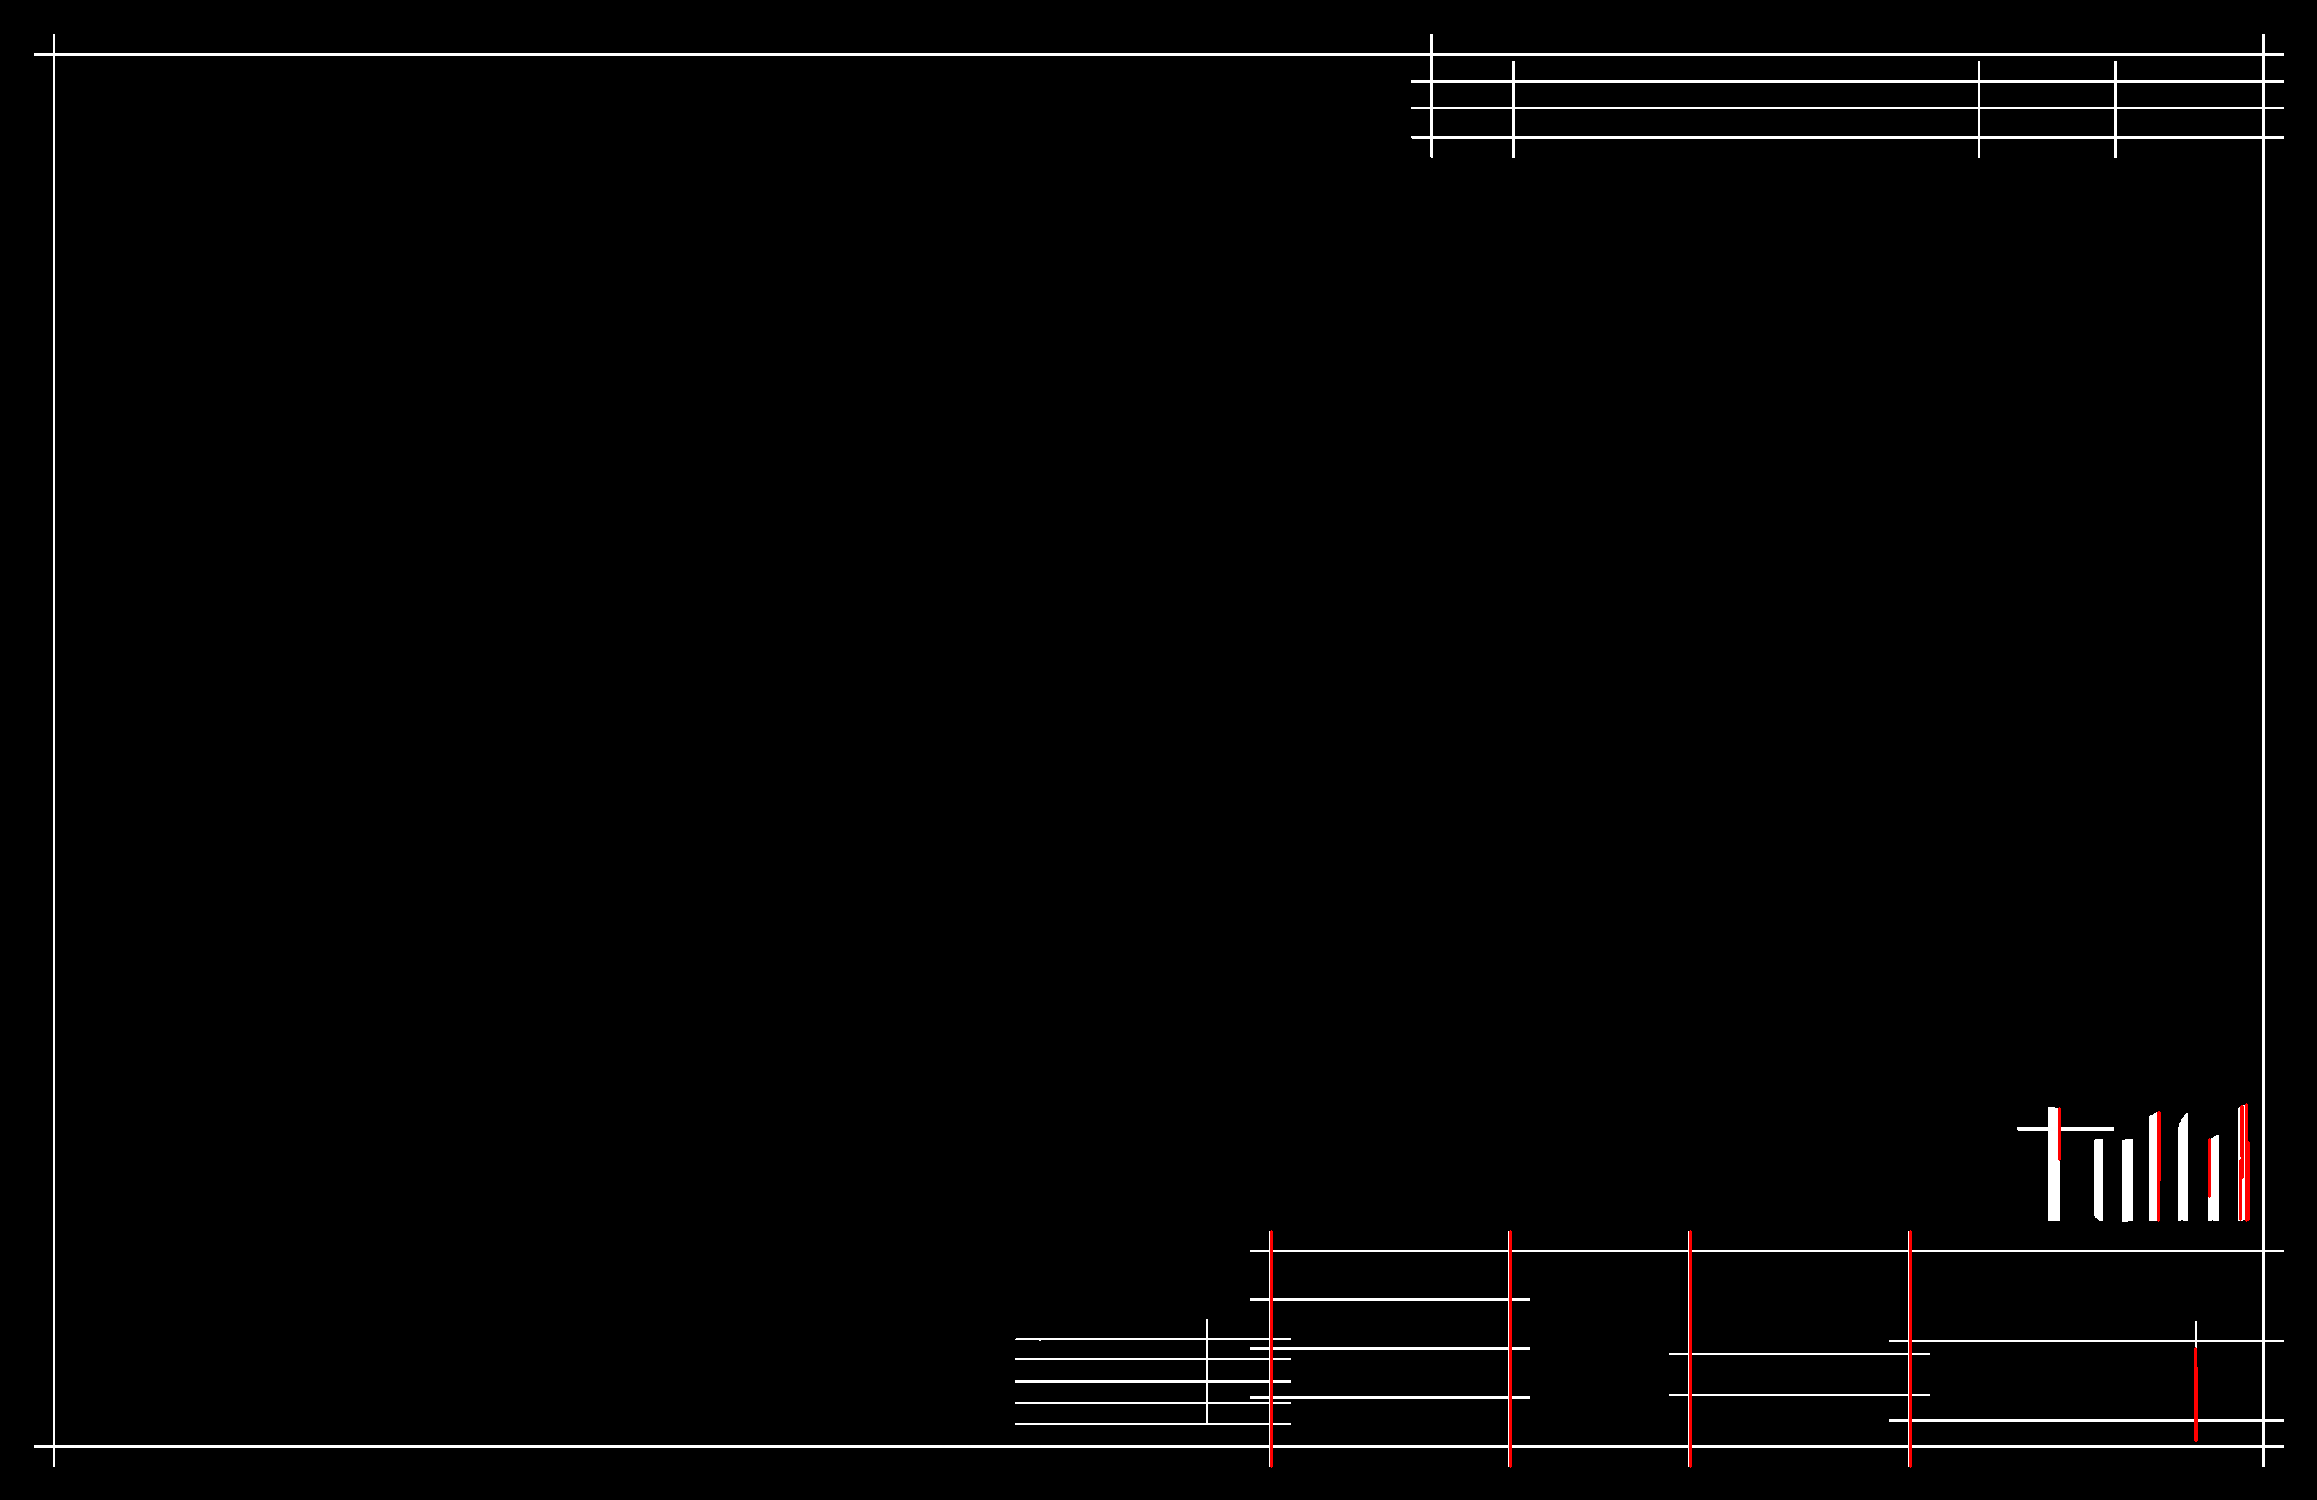

In [8]:
title_block = straight_lines[(straight_lines[:, 1] > int((temp_height * 70) / 100)) & (straight_lines[:, 3] > int((temp_height * 70) / 100))]

vertical_lines = remove_similar_lines(title_block[abs(title_block[:, 0] - title_block[:, 2]) == 0])
vertical_tops = select_top_right_lines(vertical_lines)
# vertical_lines[:, 2] = template_width

temp_copy = template.copy()
for line in vertical_tops:
    x1, y1, x2, y2 = line
    cv2.line(temp_copy, (x1, y1), (x2, y2), color, thickness)
    # cv2.rectangle(temp_copy, (x1, y1), (x2, y2), color, cv2.FILLED)

Image.fromarray(temp_copy)

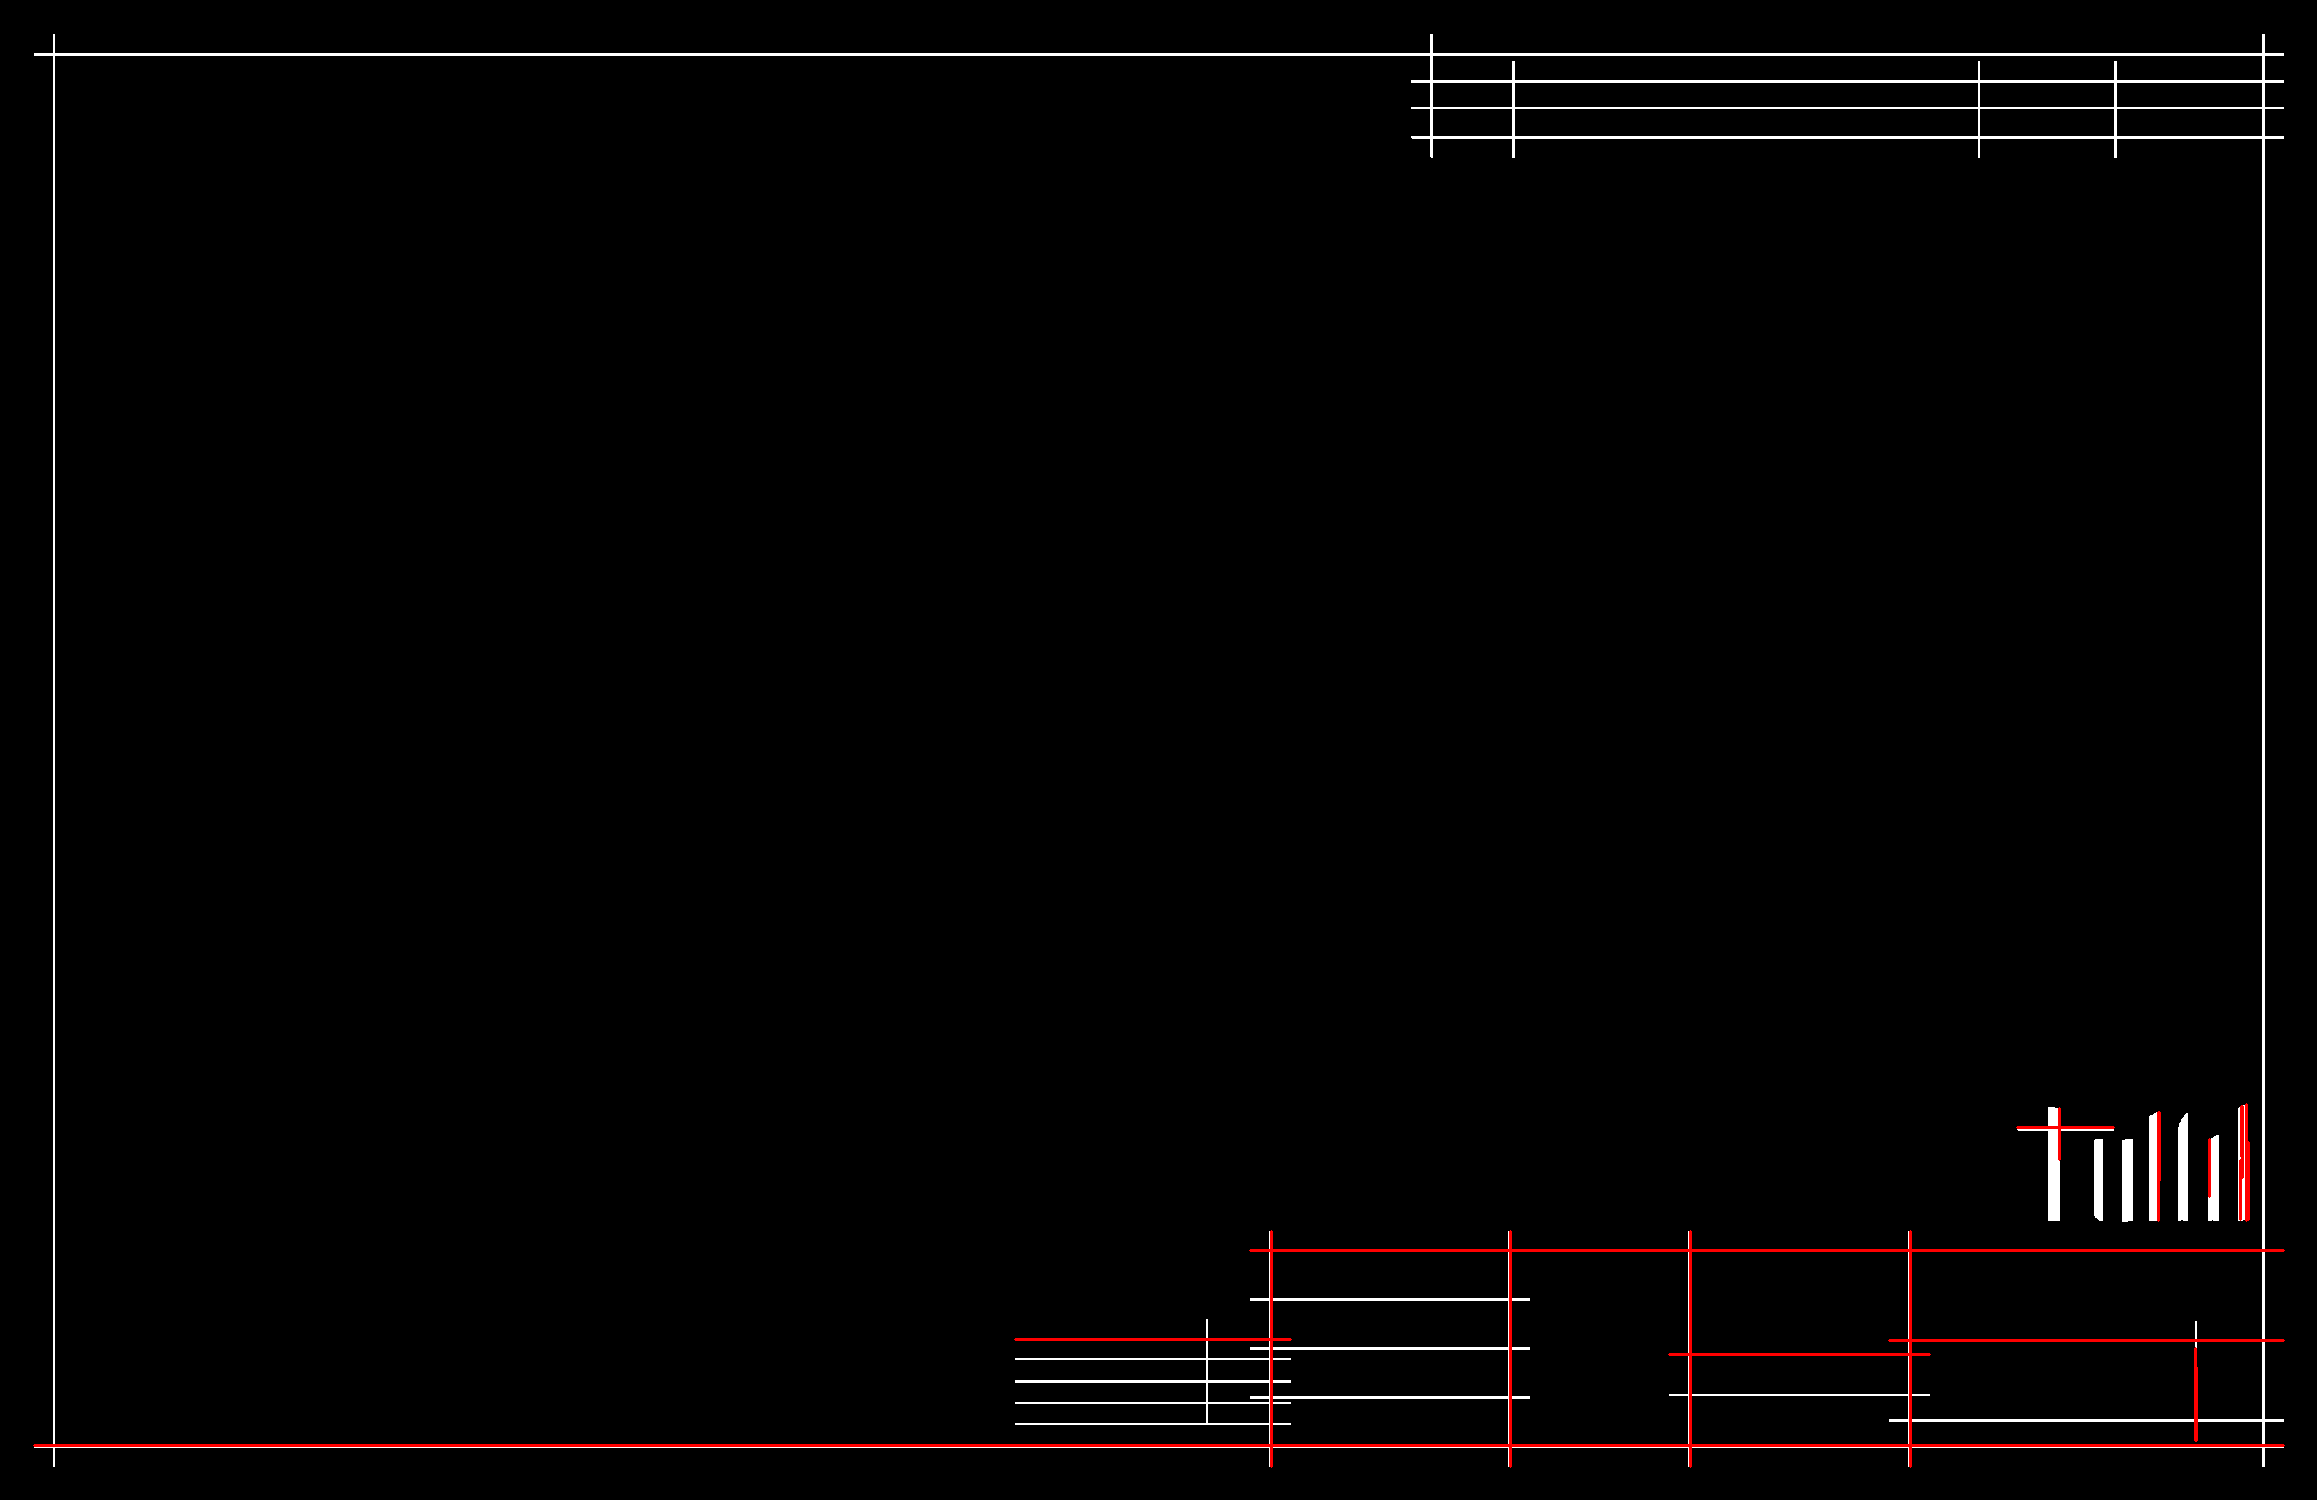

In [9]:
temp_copy = template.copy()

for line in np.vstack((vertical_tops, horizontal_tops)):
    x1, y1, x2, y2 = line
    cv2.rectangle(temp_copy, (x1, y1), (x2, y2), color, thickness)

Image.fromarray(temp_copy)

In [10]:
print(np.vstack((vertical_lines, horizontal_lines)).shape)
print(vertical_lines.shape, horizontal_lines.shape)

(31, 4)
(15, 4) (16, 4)


In [11]:
vertical_tops

array([[2248, 1219, 2248, 1142],
       [2246, 1220, 2246, 1104],
       [2242, 1177, 2242, 1106],
       [2241, 1156, 2241, 1106],
       [2240, 1219, 2240, 1160],
       [2209, 1196, 2209, 1139],
       [2196, 1440, 2196, 1367],
       [2195, 1440, 2195, 1348],
       [2159, 1180, 2159, 1112],
       [2158, 1220, 2158, 1112],
       [2059, 1159, 2059, 1108],
       [1910, 1466, 1910, 1231],
       [1690, 1466, 1690, 1231],
       [1510, 1466, 1510, 1231],
       [1271, 1466, 1271, 1231]], dtype=int32)

In [12]:
horizontal_tops

array([[2017, 1127, 2113, 1127],
       [1889, 1340, 2283, 1340],
       [1669, 1354, 1929, 1354],
       [1250, 1250, 2283, 1250],
       [1015, 1339, 1290, 1339],
       [  34, 1445, 2283, 1445]], dtype=int32)

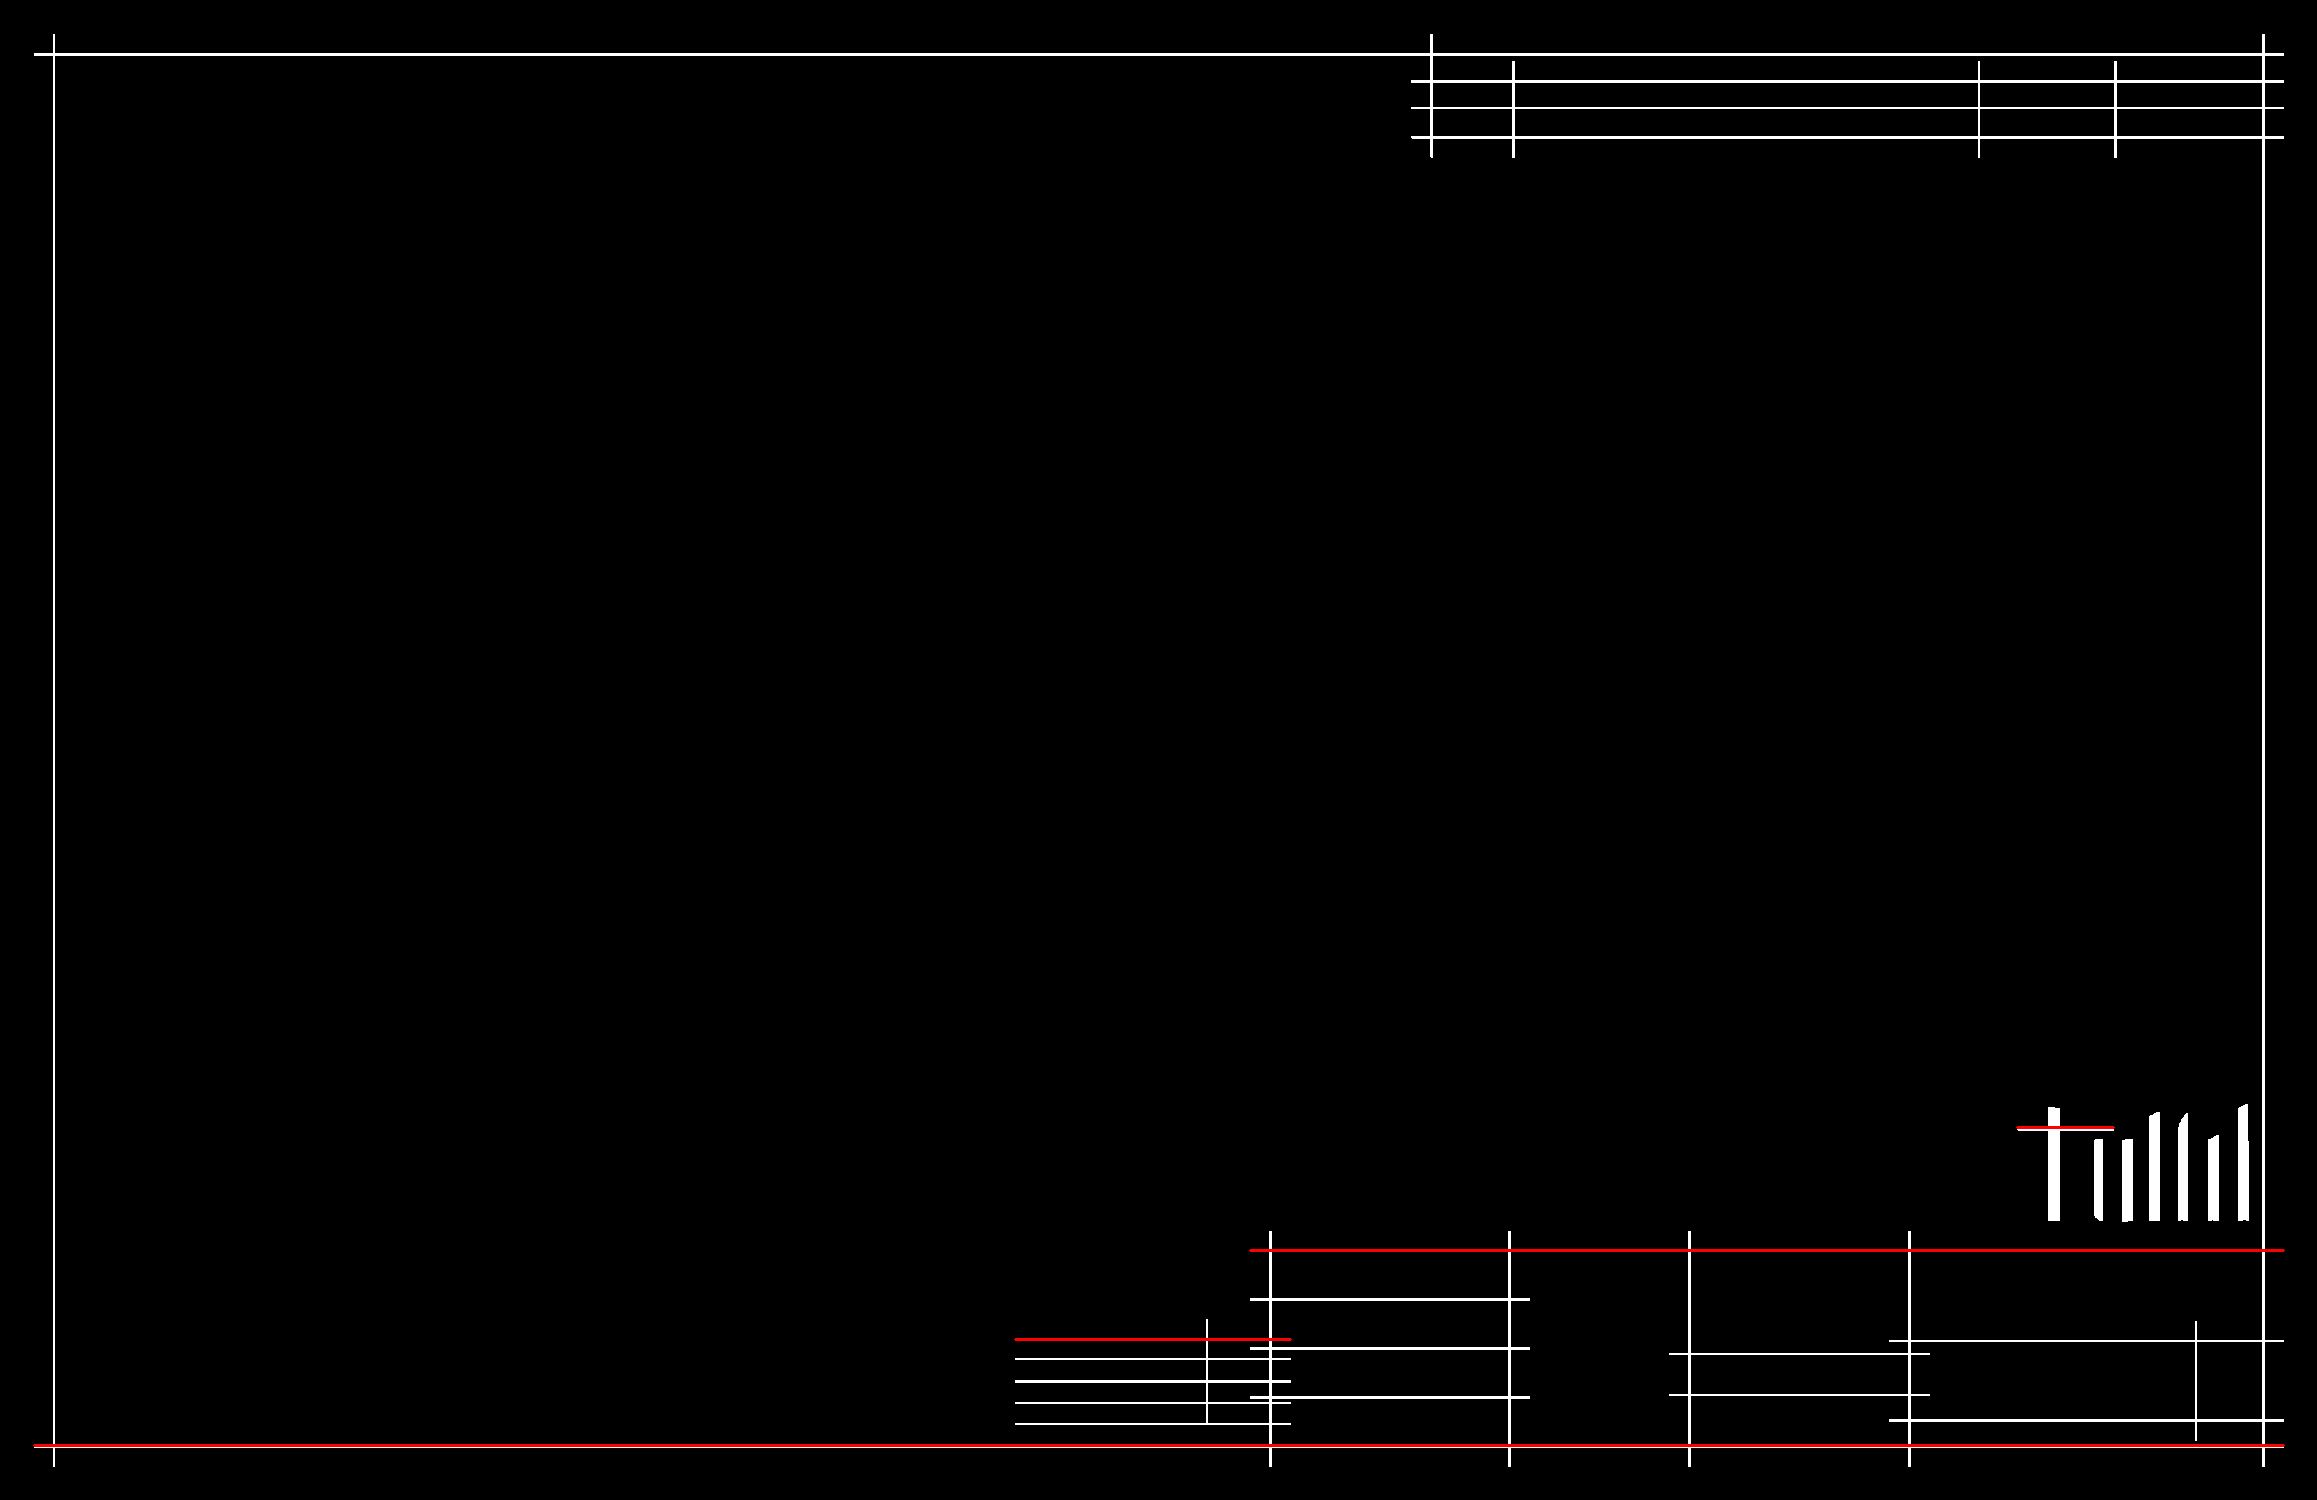

In [13]:
def select_top_lines(lines):
    lines = np.array(lines)
    selected_lines = []

    while len(lines) > 0:
        lines = sorted(lines, key=lambda x: x[1])

        picked_line = lines[0]
        selected_lines.append(picked_line)

        x1_pick, y1_pick, x2_pick, _ = picked_line
        min_x, max_x = min(x1_pick, x2_pick), max(x1_pick, x2_pick)

        new_lines = []
        for line in lines[1:]:
            x1, y1, x2, _ = line
            line_min_x, line_max_x = min(x1, x2), max(x1, x2)
            if not (y1 > y1_pick and line_min_x >= min_x and line_max_x <= max_x):
                new_lines.append(line)

        lines = new_lines

    return np.array(selected_lines)


temp_copy = template.copy()
horizontal_bottom_borders = select_top_lines(horizontal_lines)
for line in horizontal_bottom_borders:
    x1, y1, x2, y2 = line
    cv2.line(temp_copy, (x1, y1), (x2, y2), color, thickness)
    # cv2.rectangle(temp_copy, (x1, y1), (x2, y2), color, cv2.FILLED)

Image.fromarray(temp_copy)

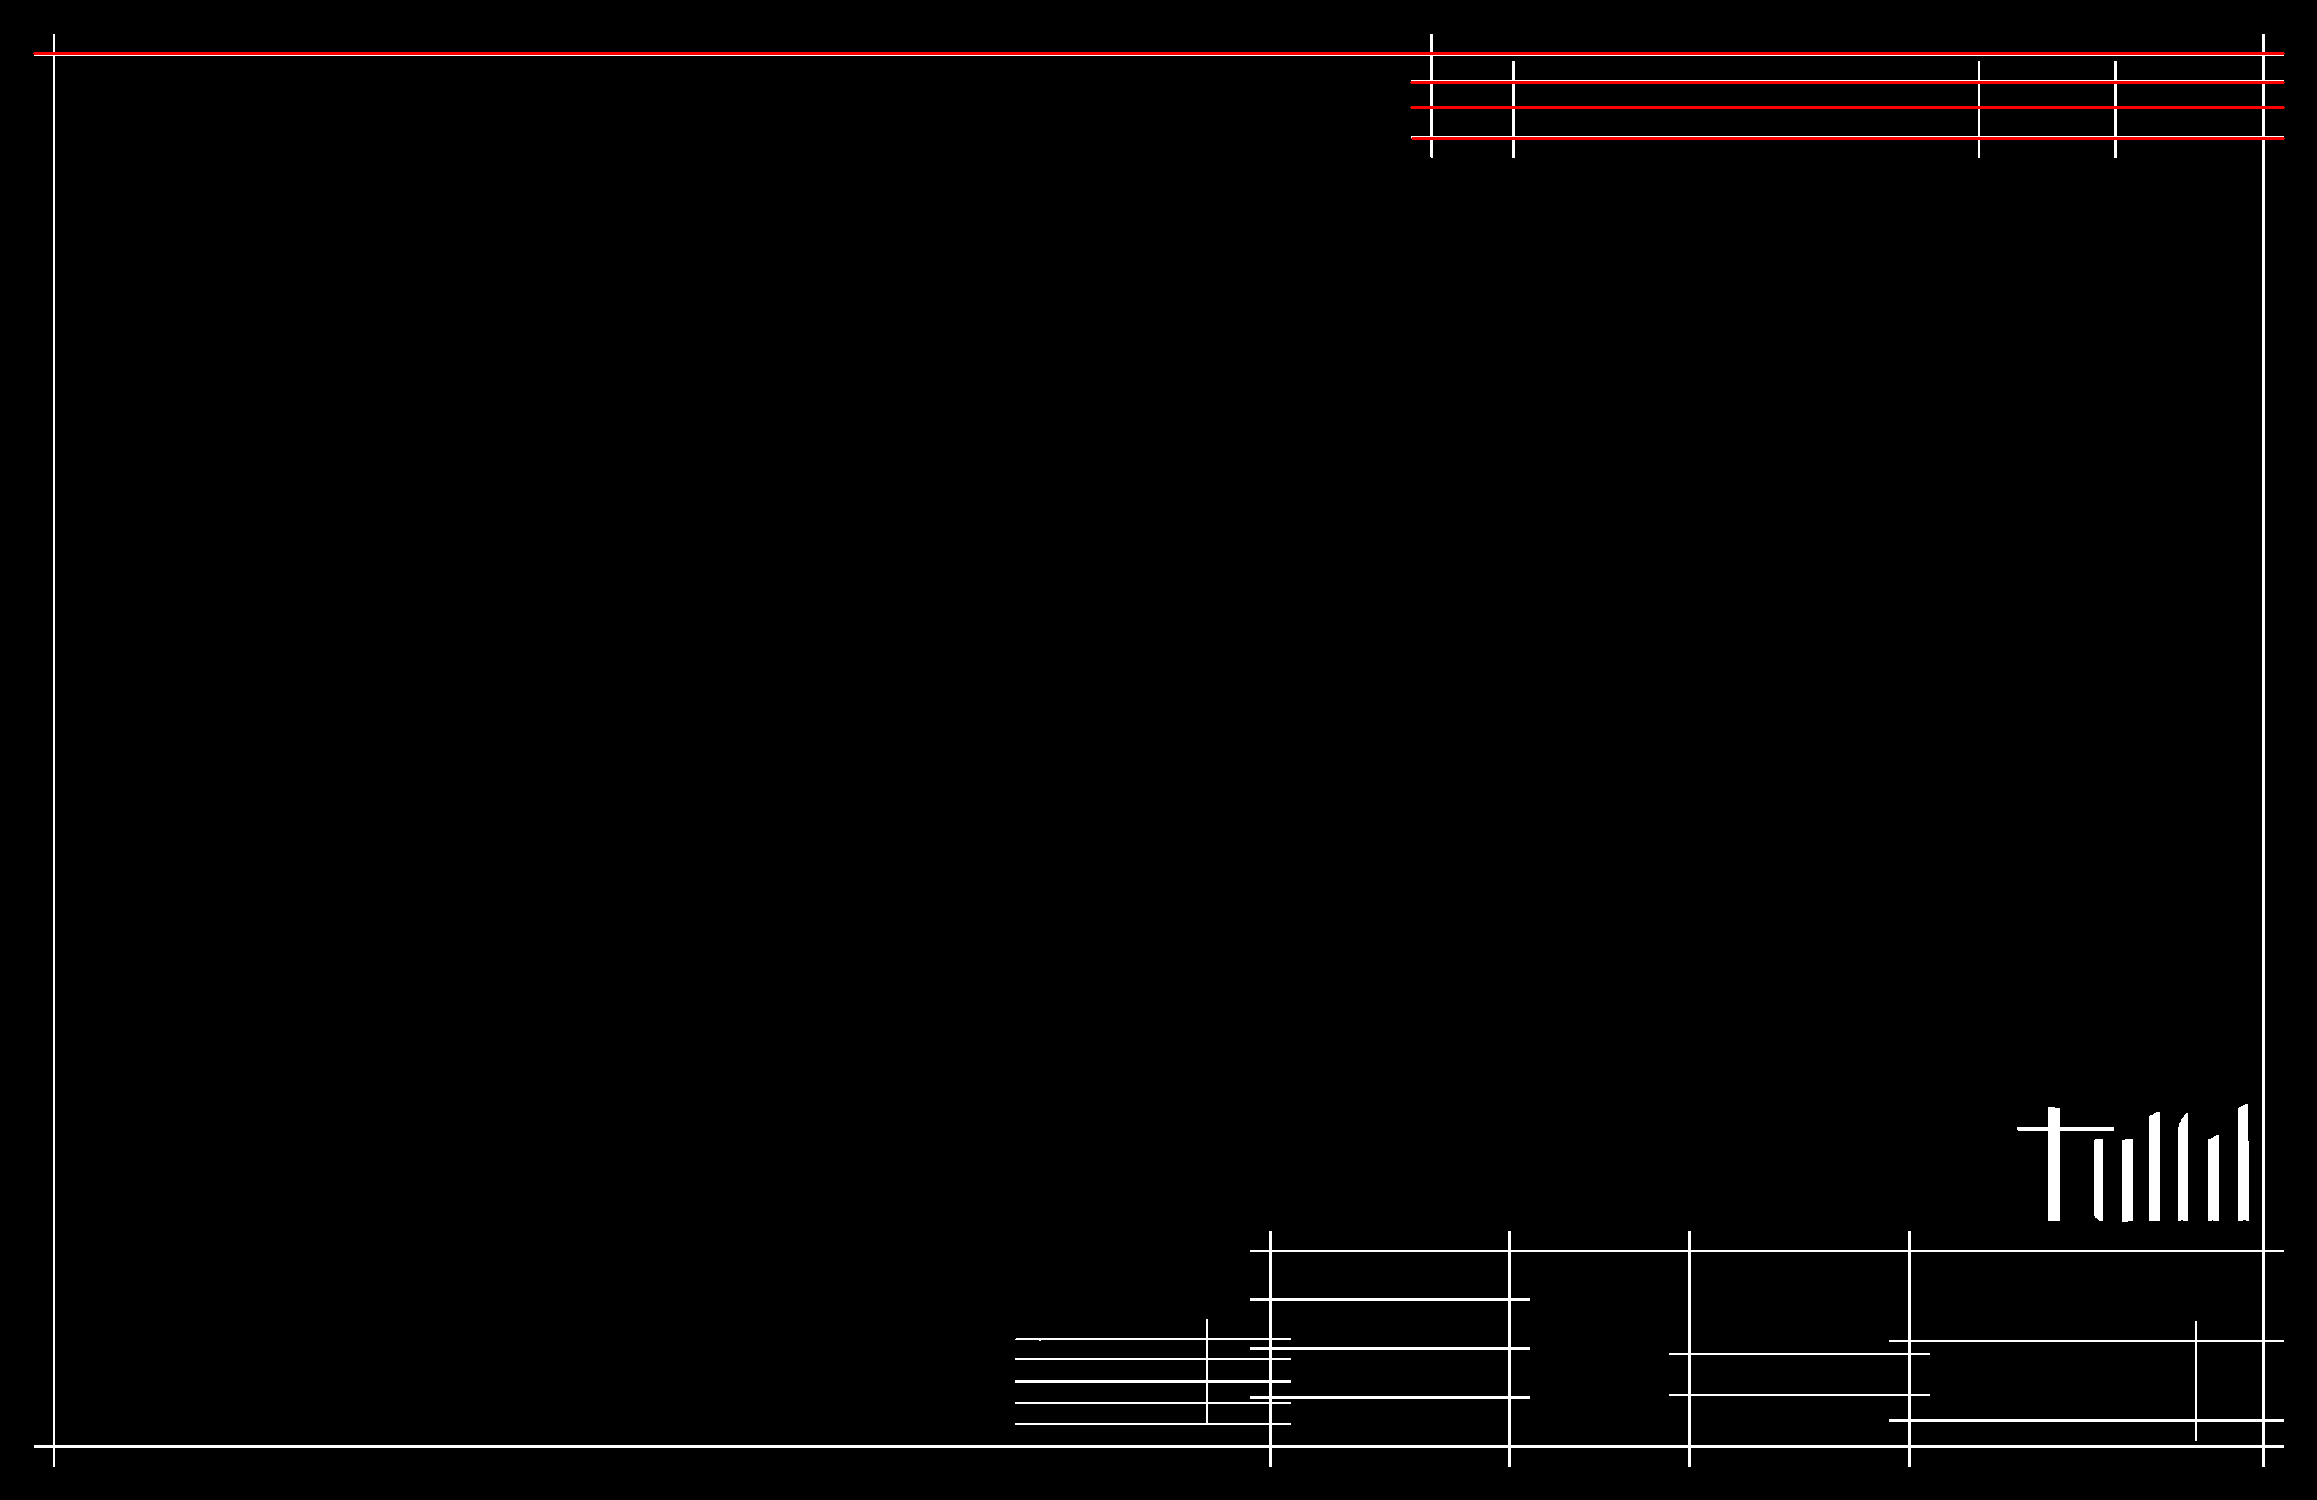

In [14]:
top_horizontal_lines = straight_lines[(straight_lines[:, 1] < int((temp_height * 30) / 100)) & (straight_lines[:, 3] < int((temp_height * 30) / 100))]

top_horizontal_lines = remove_similar_lines(top_horizontal_lines[abs(top_horizontal_lines[:, 1] - top_horizontal_lines[:, 3]) == 0])
temp_copy = template.copy()
# top_horizontal_tops = select_top_right_lines(top_horizontal_lines)
# horizontal_lines[:, 3] = template_height

for line in top_horizontal_lines:
    x1, y1, x2, y2 = line
    cv2.line(temp_copy, (x1, y1), (x2, y2), color, thickness)
    # cv2.rectangle(temp_copy, (x1, y1), (x2, y2), color, thickness)

Image.fromarray(temp_copy)

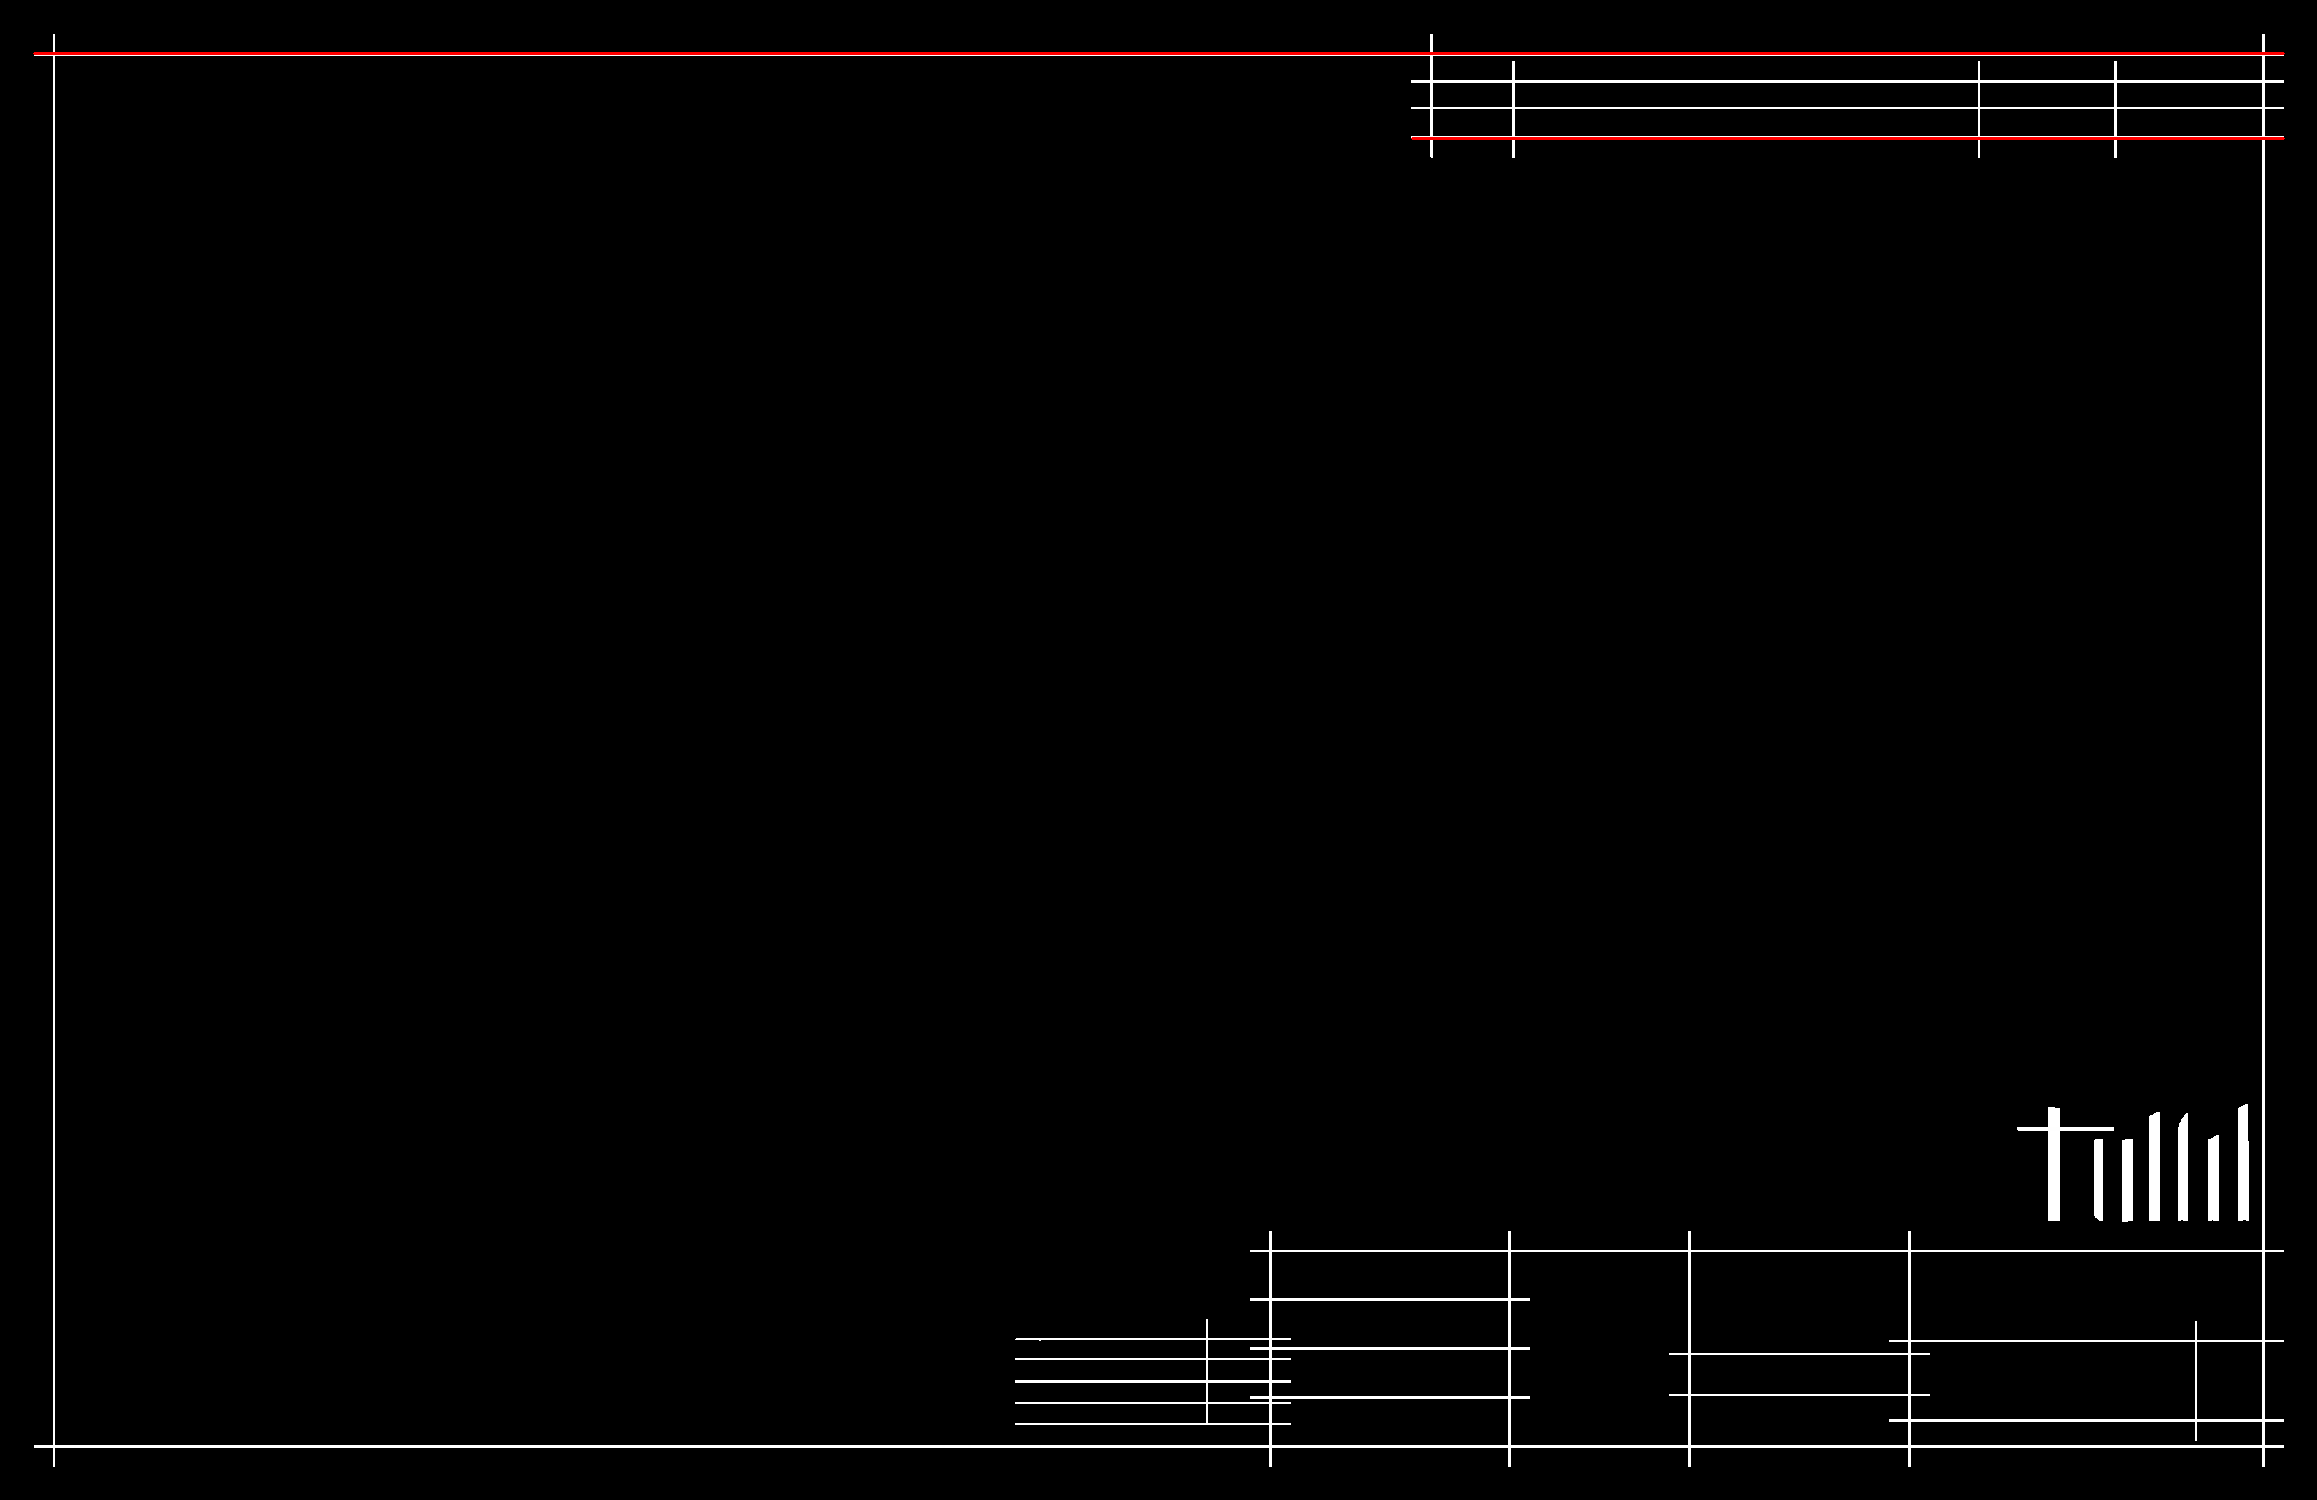

In [15]:
def keep_below_bottom_line(lines, threshold=10):
    lines = np.array(lines)

    if len(lines) == 0:
        return np.array([])

    lines = sorted(lines, key=lambda x: -x[1])

    kept_lines = []
    picked_line = lines[0]
    kept_lines.append(picked_line)

    pick_x1, pick_y1, pick_x2, pick_y2 = picked_line
    pick_min_x, pick_max_x = min(pick_x1, pick_x2), max(pick_x1, pick_x2)

    for line in lines[1:]:
        x1, y1, x2, y2 = line
        min_x, max_x = min(x1, x2), max(x1, x2)

        if (min_x >= pick_min_x - threshold) and (max_x <= pick_max_x + threshold):
            continue
        else:
            kept_lines.append(line)

    return np.array(kept_lines)


top_horizontal_borders = keep_below_bottom_line(top_horizontal_lines)

temp_copy = template.copy()
for line in top_horizontal_borders:
    x1, y1, x2, y2 = line
    cv2.line(temp_copy, (x1, y1), (x2, y2), color, thickness)
    # cv2.rectangle(temp_copy, (x1, y1), (x2, y2), color, cv2.FILLED)

Image.fromarray(temp_copy)

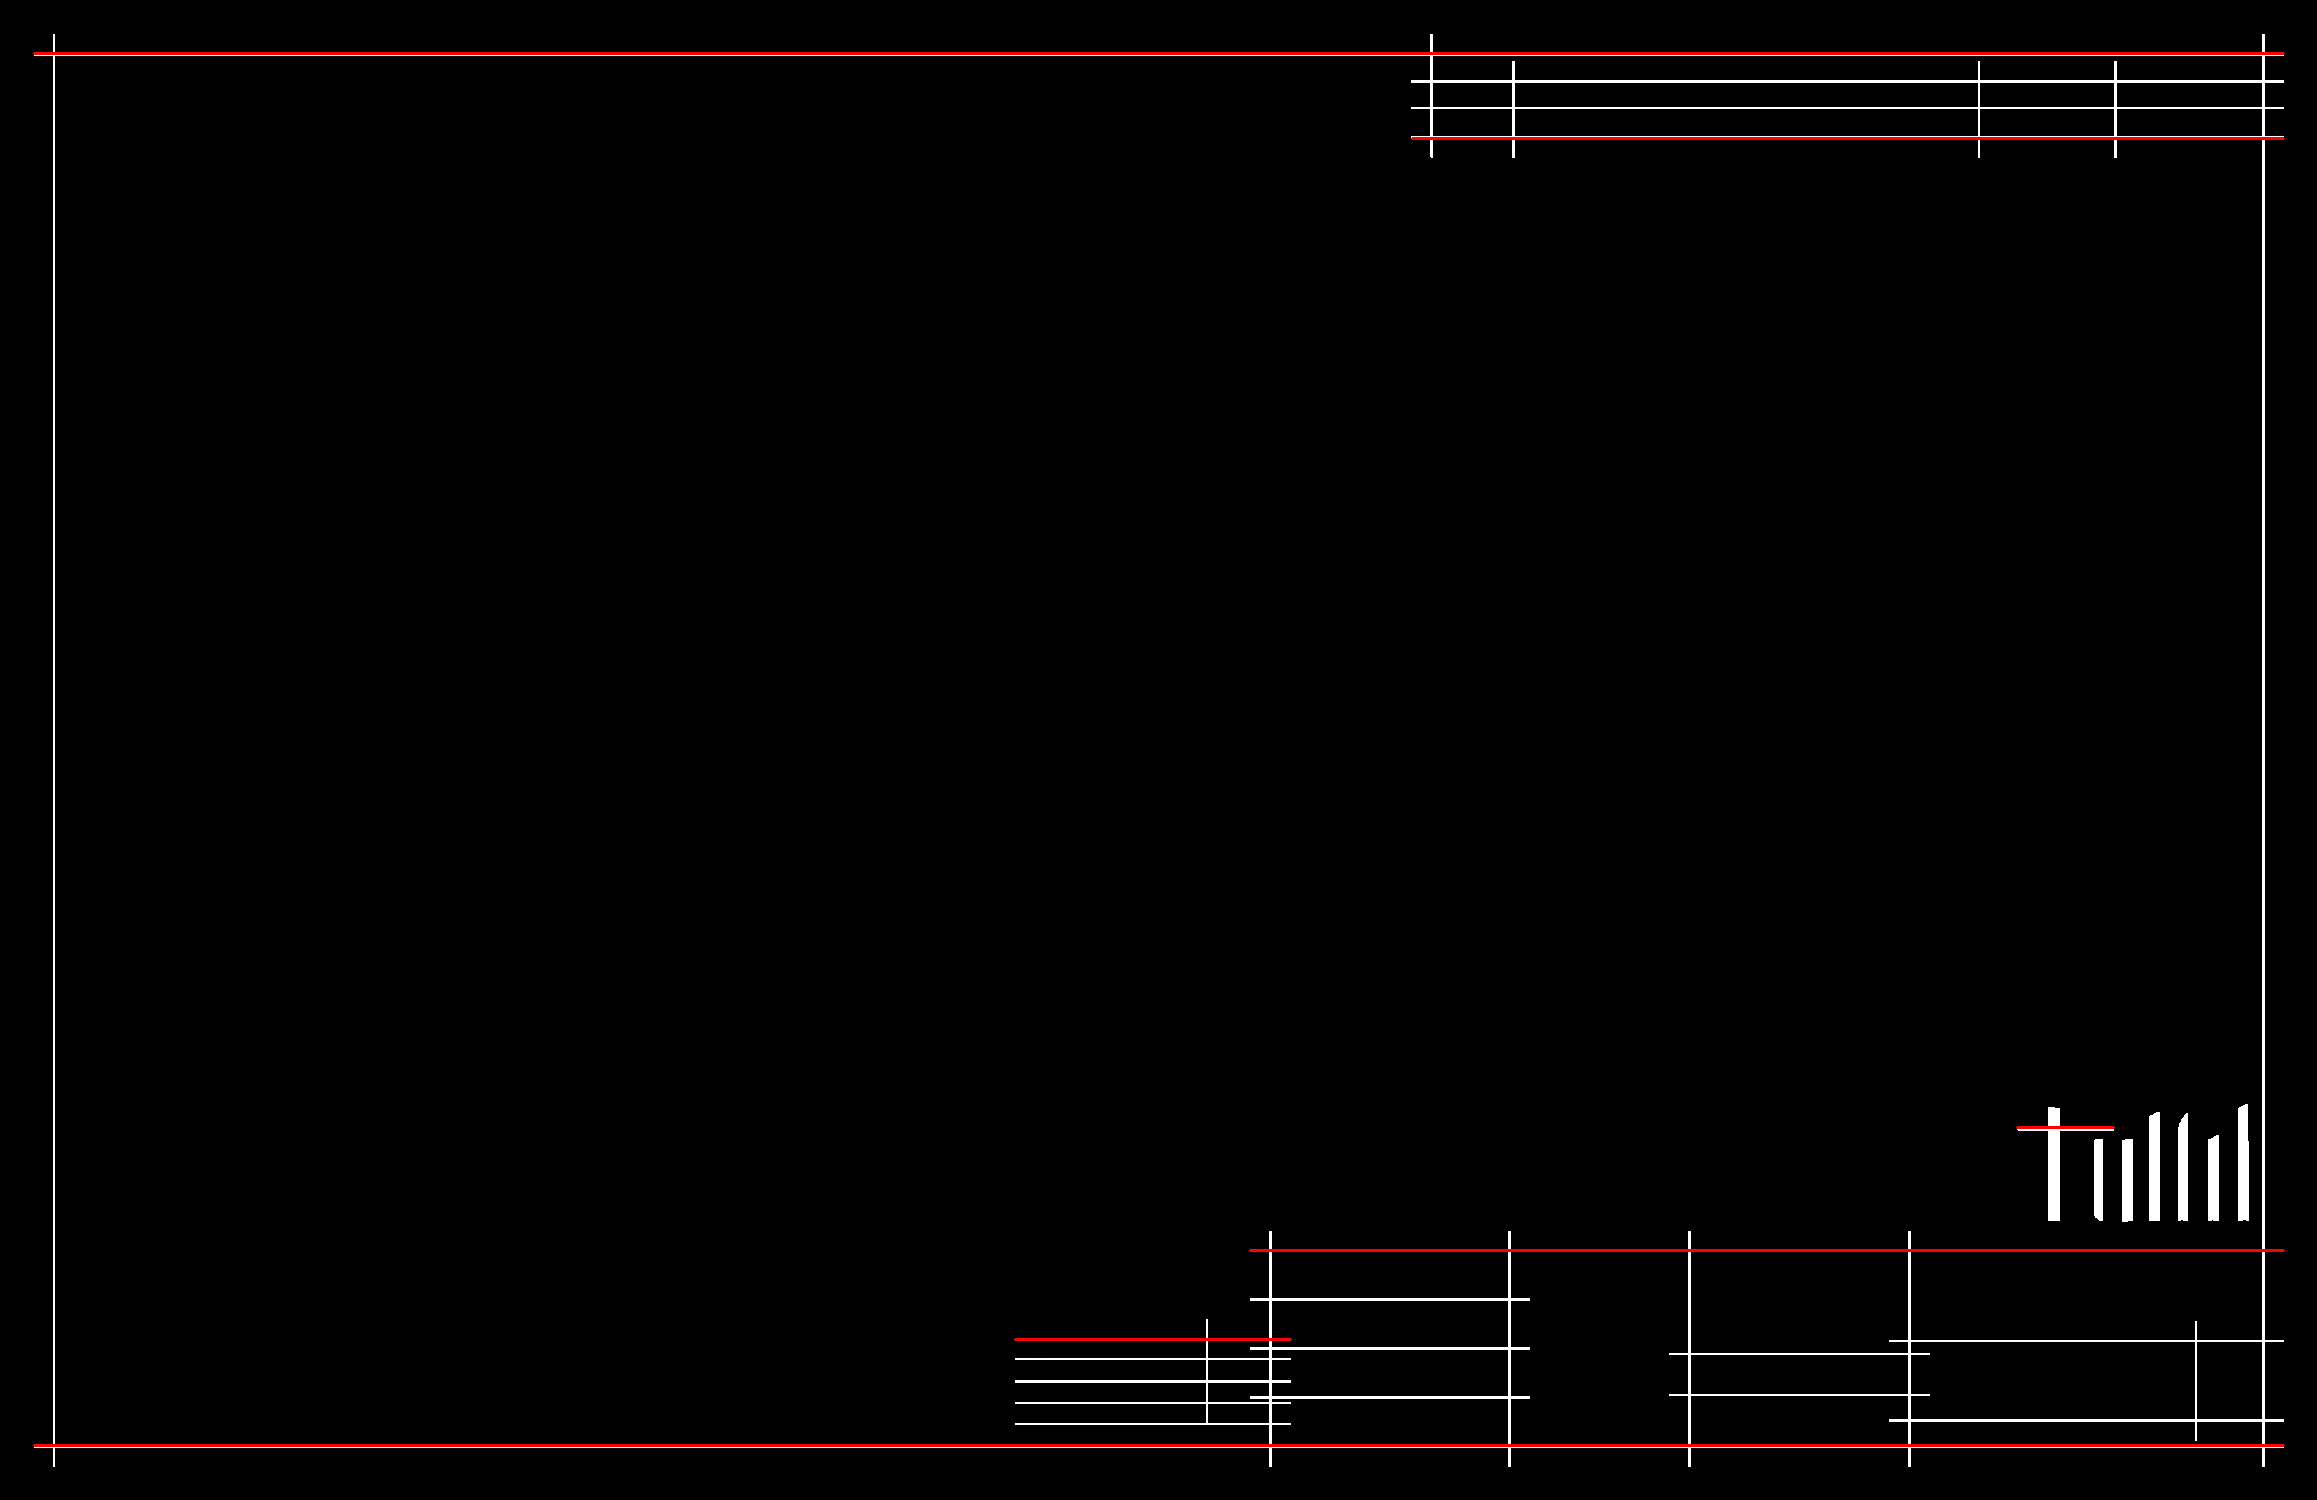

In [16]:
borders = horizontal_bottom_borders

if top_horizontal_borders.shape[0] > 0:
    borders = np.vstack([borders, top_horizontal_borders])

temp_copy = template.copy()
for line in borders:
    x1, y1, x2, y2 = line
    cv2.line(temp_copy, (x1, y1), (x2, y2), color, thickness)
    # cv2.rectangle(temp_copy, (x1, y1), (x2, y2), color, cv2.FILLED)

Image.fromarray(temp_copy)